This notebook is used to make plots. The notebook is converted to a plain python text file using [jupytext](https://jupytext.readthedocs.io/en/latest/)

In [4]:
import os
import numpy as np
import pandas as pd

In [2]:
os.chdir("/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs")
# print(os.getcwd())
# !module load python-data/3.7.6-1
# !python -m pip install jupytext
!python -m jupytext --sync MakePlots.ipynb

[jupytext] Reading MakePlots.ipynb in format ipynb
[jupytext] Updating MakePlots.py


In [84]:
!module spider latex

Lmod has detected the following error:  Unable to find: "latex".





# Energy (x) vs Uncertainty (y) plot
In this plot we load the python model for each batch in run 1 of a given Dataset/Strategy/Batches combo (e.g. AA_D_EXP ) and make a plot which shows where was the uncertainty reduced the most. The data for this plot is present in `Puhti` under `/scratch/project_2000382/ghoshkun/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs`

In [25]:
import os
os.getcwd()

'/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs'

Set the current working directory to where the data exists

In [26]:
os.chdir("/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs")
assert os.getcwd() == "/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs"

# Plot A vs D

In [4]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib as mpl
%matplotlib inline

def set_mpl_params(matplotlib):
    plt.figure(figsize=(6,4), dpi=200)
    # formatting plots
    font = {'family' : 'monospace', 'size'   : 15, 'sans-serif':'Nimbus'}
    lines = {"linewidth": 4}

    matplotlib.rc('font', **font)
    matplotlib.rc('lines', **lines)
    # matplotlib.rc('text', **{'usetex': True})
    
def get_labels():
    labels = "A B C D E F G".split(" ")
    labs = [[_] for _ in labels]
    return labs, labels

def set_mpl_params_meeting(matplotlib):
    plt.figure(figsize=(6,4), dpi=100)
    # formatting plots
    font = {'family' : 'monospace', 'size'   : 10, 'sans-serif':'Nimbus'}
    lines = {"linewidth": 2}

    matplotlib.rc('font', **font)
    matplotlib.rc('lines', **lines)
    # matplotlib.rc('text', **{'usetex': True})

In [5]:
def get_msb(aa_a):
    batch_sizes = np.cumsum(aa_a.batch_size.to_numpy()) // 1000
    means = aa_a.mean_vals.to_numpy()
    stds = aa_a.std_vals.to_numpy()
    return means, stds, batch_sizes

def get_means_stds_batchsize(aa_a, aa_d):
    assert (aa_a.batch_size == aa_d.batch_size).all(), "batch_size column must be the same, in the two files passed in the argument."

    # batch_sizes = np.arange(0,17,batch_size) + 1
    batch_sizes = np.cumsum(aa_a.batch_size.to_numpy()) // 1000

    aa_a_means = aa_a.mean_vals.to_numpy()
    aa_d_means = aa_d.mean_vals.to_numpy()

    aa_a_stds = aa_a.std_vals.to_numpy()
    aa_d_stds = aa_d.std_vals.to_numpy()

    stds = [aa_a_stds,
         [],
         [],
         aa_d_stds,
         [],
         [],
         []]

    means = [aa_a_means,
         [],
         [],
         aa_d_means,
         [],
         [],
         []]
    return means, stds, batch_sizes

In [6]:
def plot_strategy_a_vs_d(dataset_name, means, stds, labels):
    for idx, (mean, std) in enumerate(zip(means,stds)):
        if labels[idx] in ['A', 'D']:
            """
            Only plot strategy A and D.
            """
            _ = plt.errorbar(batch_sizes, mean, std) #, capsize=lines['linewidth'])
            _ = plt.scatter(batch_sizes, mean, label=labels[idx])
    plt.grid()
    plt.xlabel("Dataset size in 1000s")
    plt.ylabel("MAE (eV)")
    plt.gca().tick_params(axis='x', which='minor', bottom=True)
    plt.xscale("linear")
    #plt.xlim((0, 33))
    plt.ylim((0,0.6))
    # plt.xscale("log", basex=2)
    #     sformatter = mpl.ticker.ScalarFormatter()
    #     sformatter.set_scientific(False)
    formatter = mpl.ticker.FuncFormatter(lambda y, _: '{:0.0f}'.format(y))
    # use plt.gca() whenever there is a need for axis.<something>
    plt.gca().xaxis.set_major_formatter(formatter)
    
    #plt.xticks(range(0, 33))
    if dataset_name:
        plt.title(f"{dataset_name} - Strategy A vs D")

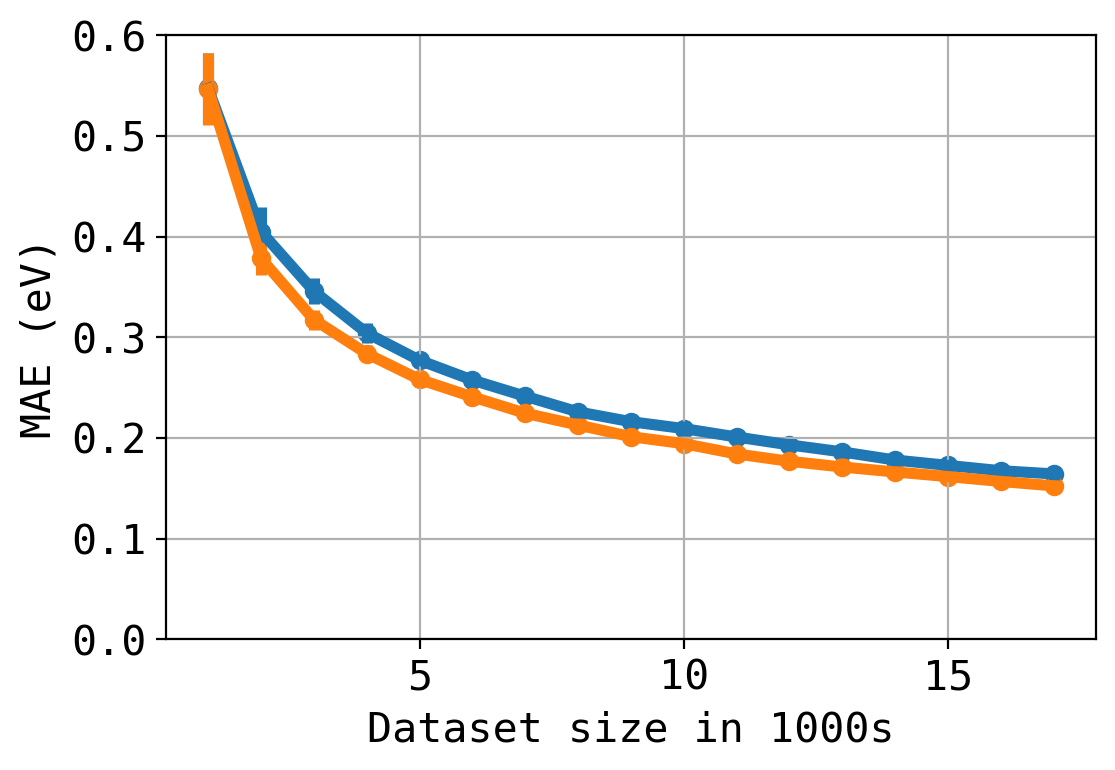

In [5]:
aa_a = pd.read_csv("csv_files/Active_learning_results - AA_A_1k.csv")
aa_d = pd.read_csv("csv_files/Active_learning_results - AA_D_1k.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = None, means=means, stds=stds, labels=labels)    

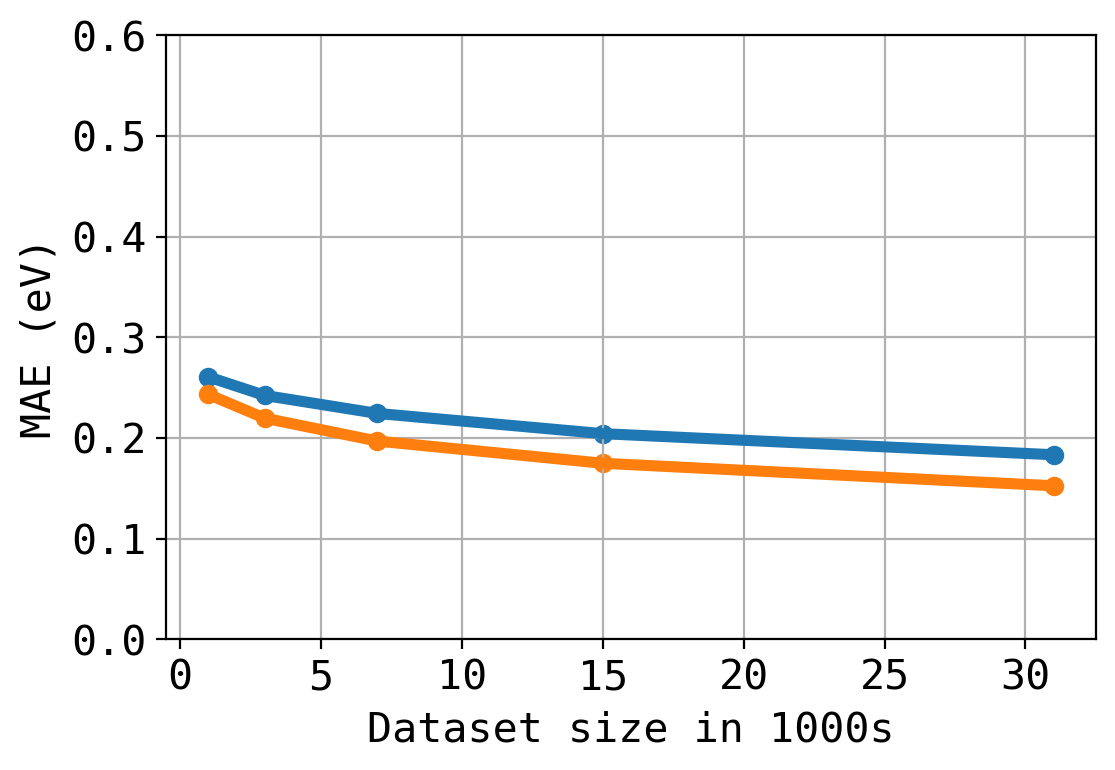

In [32]:
aa_a = pd.read_csv("csv_files/old_csvs/Active_learning_results - QM9_A_EXP_physdays.csv")
aa_d = pd.read_csv("csv_files/old_csvs/Active_learning_results - QM9_D_EXP_physdays.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = None, means=means, stds=stds, labels=labels)    

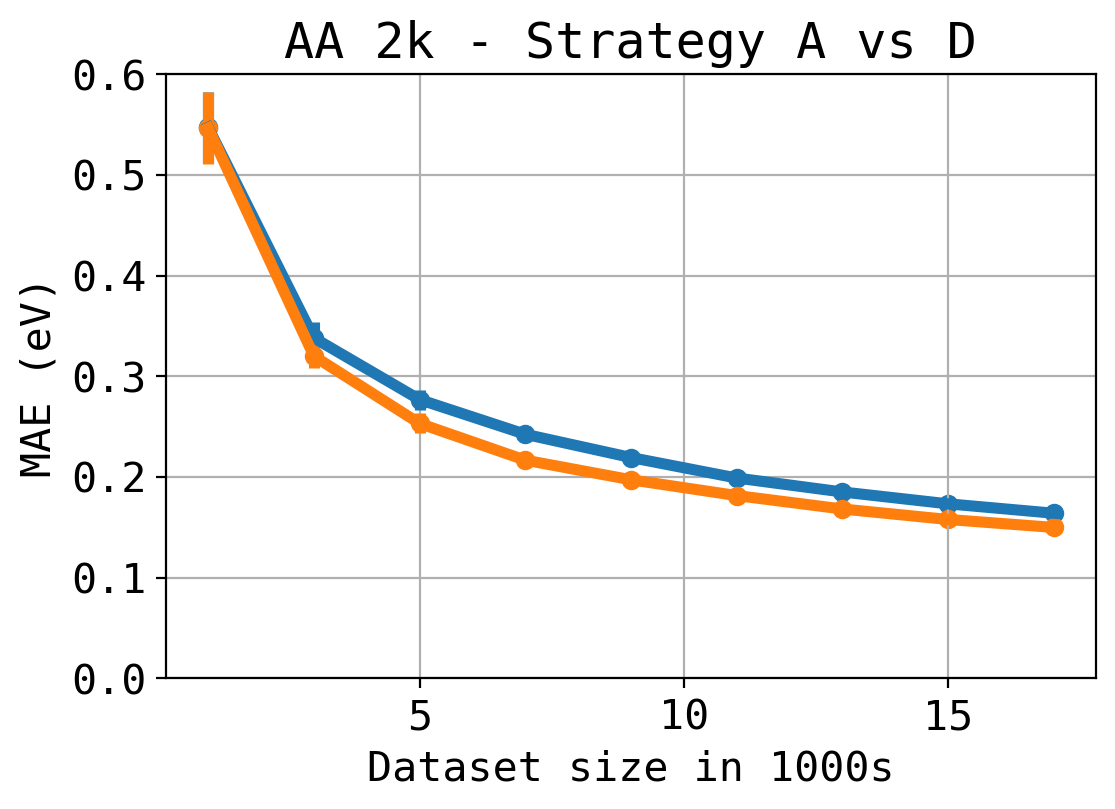

In [34]:
aa_a = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_A_2k.csv")
aa_d = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_2k.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = "AA 2k", means=means, stds=stds, labels=labels)    

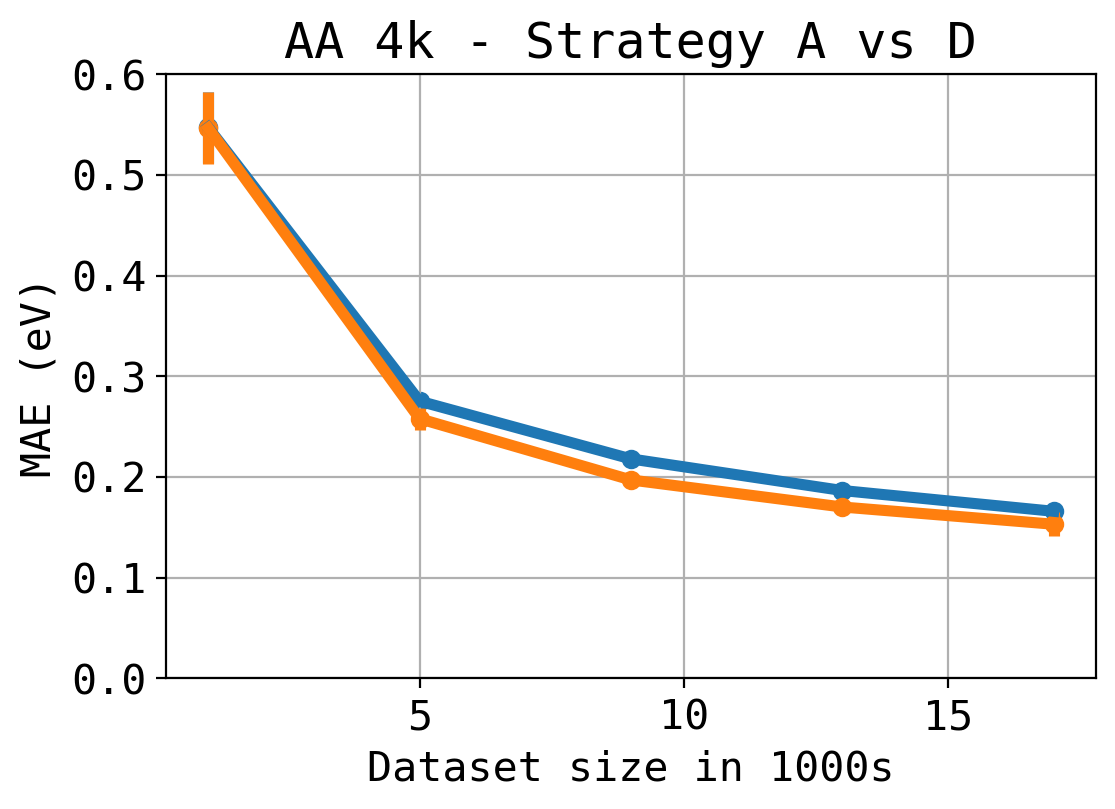

In [36]:
aa_a = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_A_4k.csv")
aa_d = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_4k.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = "AA 4k", means=means, stds=stds, labels=labels) 

[ 1  3  7 15 31]


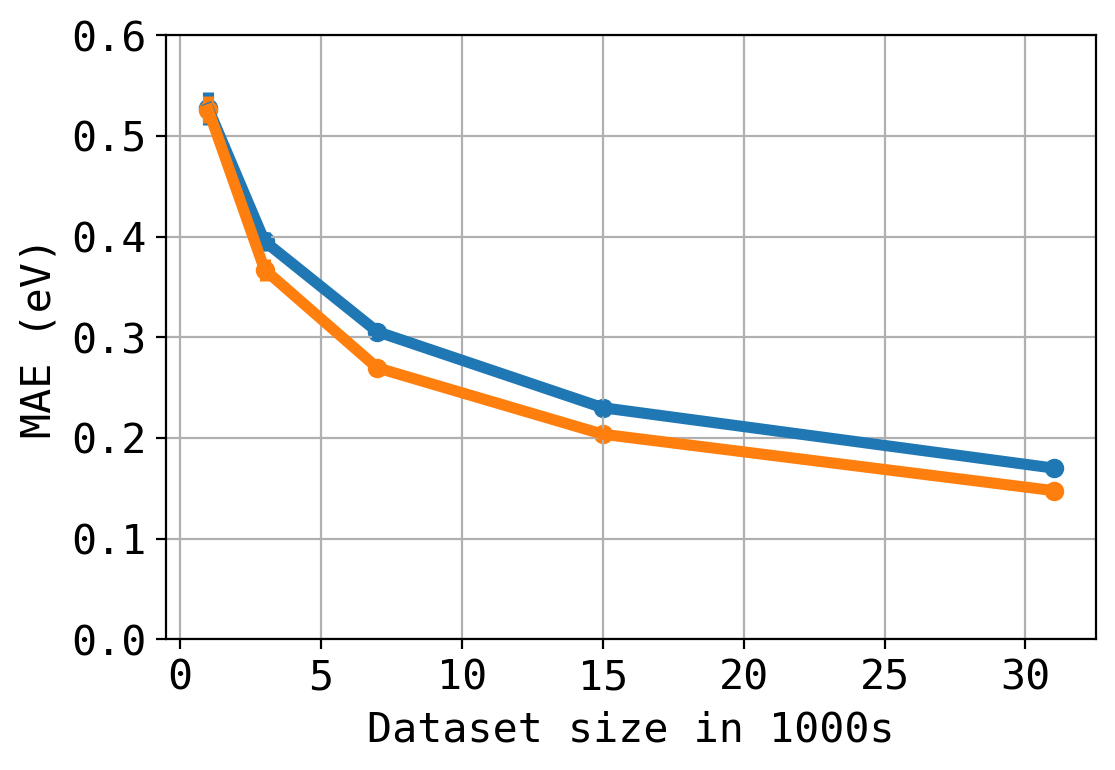

In [38]:
aa_a = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_A_EXP_old.csv")
aa_d = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_EXP_old.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
print(batch_sizes)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = None, means=means, stds=stds, labels=labels)    

[ 1  3  7 15 31]


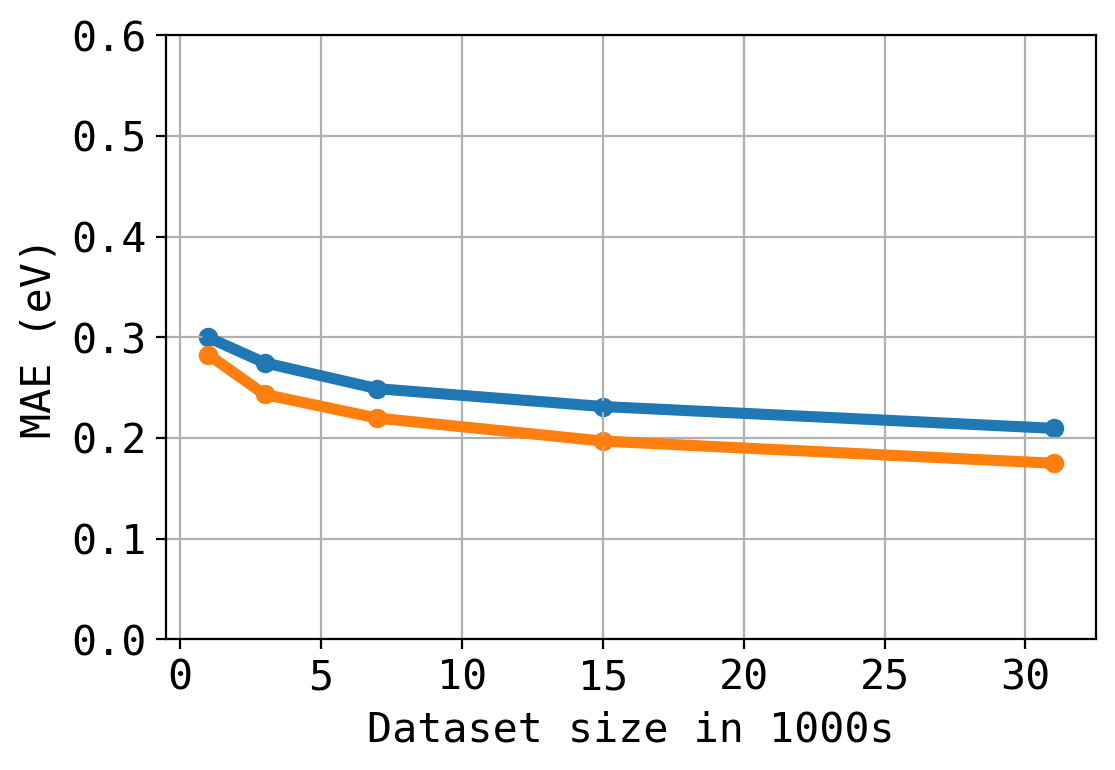

In [39]:
aa_a = pd.read_csv("csv_files/old_csvs/Active_learning_results - QM9_A_EXP_old.csv")
aa_d = pd.read_csv("csv_files/old_csvs/Active_learning_results - QM9_D_EXP_old.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
print(batch_sizes)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = None, means=means, stds=stds, labels=labels)    


[ 1  2  4  8 16]


(0.1, 0.35)

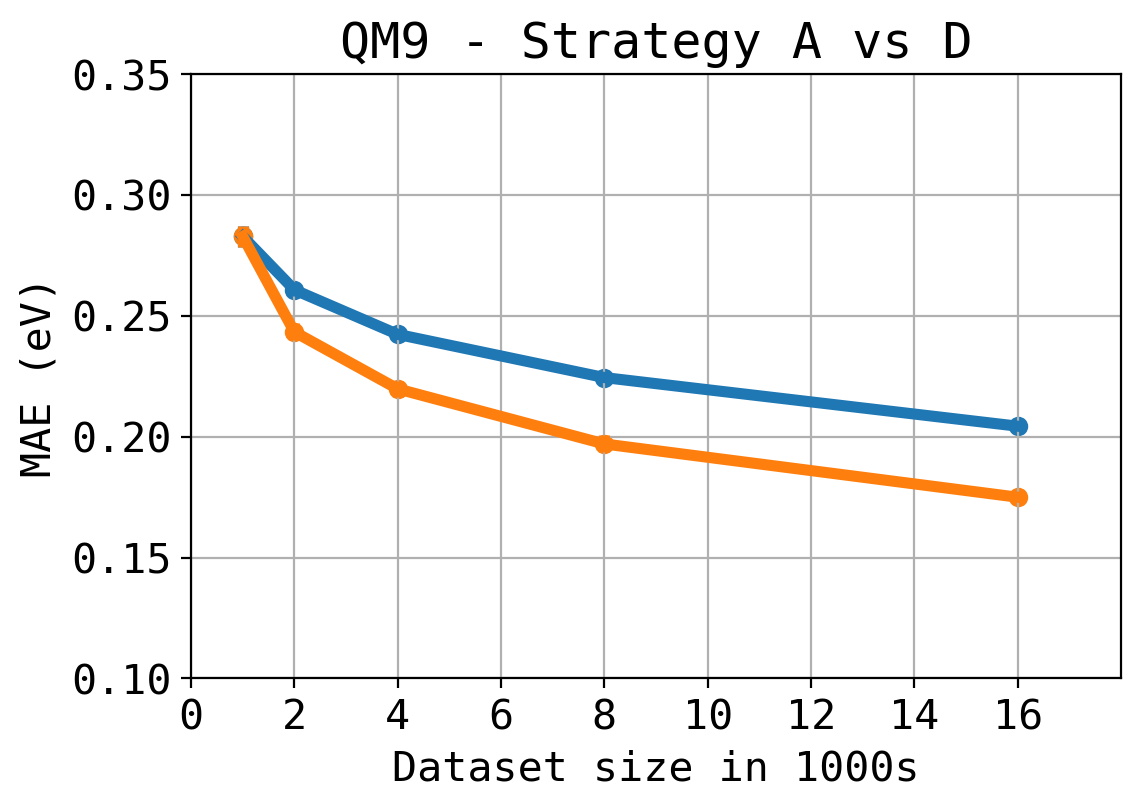

In [82]:
aa_a = pd.read_csv("csv_files/old_csvs/Active_learning_results - QM9_A_EXP.csv")
aa_d = pd.read_csv("csv_files/old_csvs/Active_learning_results - QM9_D_EXP.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
print(batch_sizes)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = "QM9", means=means, stds=stds, labels=labels)    
plt.ylim(0.1, 0.35)

[ 1  2  4  8 16]


(0.1, 0.35)

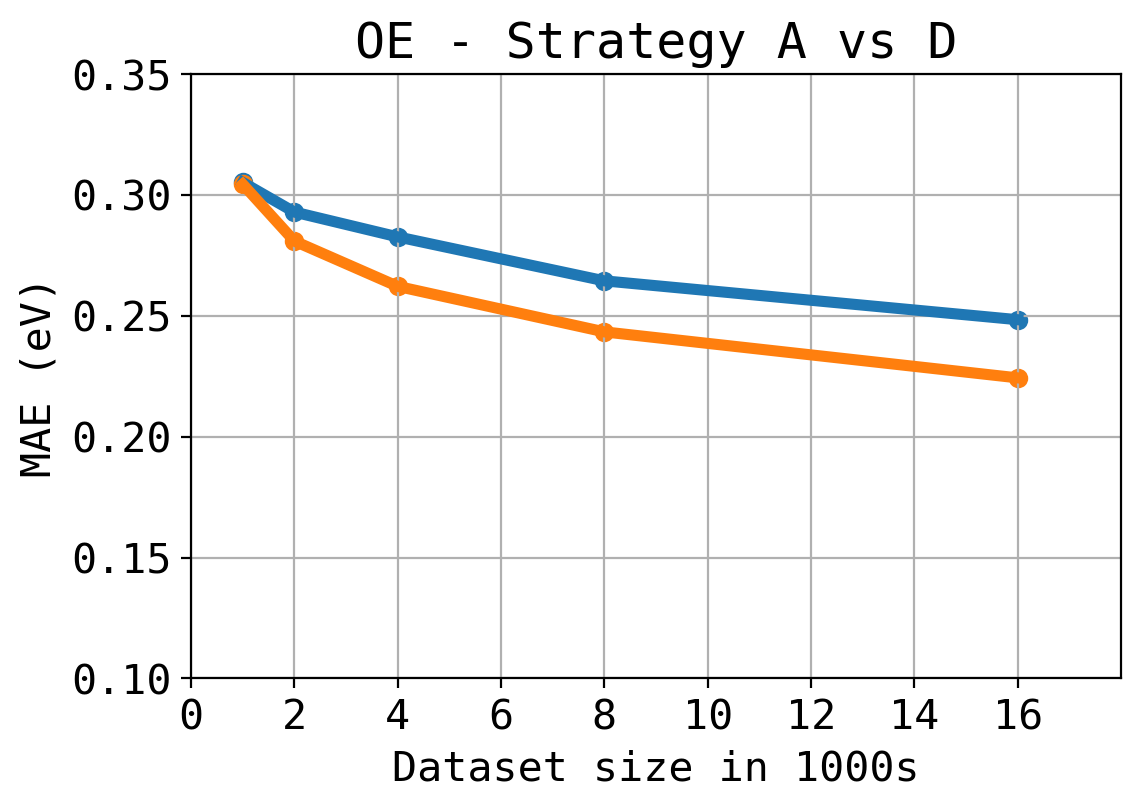

In [17]:
aa_a = pd.read_csv("csv_files/old_csvs/Active_learning_results - OE_A_EXP.csv")
aa_d = pd.read_csv("csv_files/old_csvs/Active_learning_results - OE_D_EXP.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
print(batch_sizes)
set_mpl_params(matplotlib)
labs, labels = get_labels()
# plot_strategy_a_vs_d(dataset_name = "OE", means=means, stds=stds, labels=labels)  
plot_strategy_a_vs_d(dataset_name = "OE", means=means, stds=0.001*np.ones_like(stds), labels=labels)  
plt.ylim(0.1, 0.35)

TODO : For the plot with the new data, save the means and standard deviation.

# Data savings plot

The code is based on the original implementation in 

In [7]:
from scipy.optimize import curve_fit
import numpy as np

def compute_rmse(pred, true):
    return np.mean((pred-true)**2)

def fit_curve_to_data(means, stds, labels, batch_sizes):
     # np.random.seed(0)
    coeffs = { 'A' : None, 'D' : None }
    mean_dict = {'A' : None, 'D' : None}
    for idx, (mean, std) in enumerate(zip(means,stds)):
        if labels[idx] in ['A', 'D']:
            """
            Only plot strategy A and D.
            """
#             results = curve_fit(lambda x,a,b,c,d: d + (a-d)/(1 + (x/c)**b), batch_sizes, mean, p0=[0.5, 0.5, 0.5, 0.5], bounds=(-1, [3., 1., 2, 2]), maxfev=10000)
            results = curve_fit(lambda x,a,b,c,d: d + (a-d)/(1 + (x/c)**b), batch_sizes, mean, p0=[0.5, 0.5, 0.5, 0.5], bounds=(-1, [1., 1., 2, 2]), maxfev=10000)
            a, b, c, d= results[0]
            coeffs[labels[idx]] = results[0]
            mean_dict[labels[idx]] = mean

            x = batch_sizes # np.arange(0, 17, batch_size)
            y = d + (a-d)/(1 + (x/c)**b)
            print(f"rmse {compute_rmse(y, mean)}")

    return coeffs, mean_dict


# fit_curve_to_data(means, stds, labels, batch_sizes)

In [8]:
def plot_strategy_a_vs_d(dataset_name, means, stds, labels):
    for idx, (mean, std) in enumerate(zip(means,stds)):
        if labels[idx] in ['A', 'D']:
            """
            Only plot strategy A and D.
            """
            _ = plt.errorbar(batch_sizes, mean, std)#, capsize=lines['linewidth'])
            _ = plt.scatter(batch_sizes, mean, label=labels[idx])
    plt.grid()
    plt.xlabel("Dataset size in 1000s")
    plt.ylabel("MAE (eV)")
    plt.xlim((0, 18))
    plt.xticks(range(0, 17, 2))
    plt.title(f"{dataset_name} - Strategy A vs D")
    
# plot_strategy_a_vs_d(dataset_name = "AA", means=means, stds=stds)    

In [9]:
def get_data_savings(mean_dict, coeffs, batch_sizes):
    # xticks = [_ for _ in range(0,17,batch_size)]
    data_saving = []
    a,b,c,d = coeffs['D']
    for y, batch_size in zip(mean_dict['A'], batch_sizes):
        x = c * (-1 + (a-d)/(y-d))**(1./b)
        data_saving.append(batch_size - x)

    return data_saving

# get_data_savings(mean_dict, coeffs, batch_size, batch_sizes)

In [45]:
def fx(x, coeffs):
    a,b,c,d = coeffs
    y = d + (a-d)/(1 + (x/c)**b)
    return y

def inv_fx(y, coeffs):
    a,b,c,d = coeffs
    x = c * (-1 + (a-d)/(y-d))**(1./b)
    return x

[ 1  5  9 13 17]
rmse 4.320913358992921e-06
rmse 2.9382833063828703e-07
[2.85367053e-03 6.11982094e-01 1.84837656e+00 2.79905822e+00
 3.26247615e+00]
batch_sizes used when computing data_saving percent [ 1  5  9 13 17]
Percentage data saving : [ 0.28536705 12.23964187 20.53751735 21.53121709 19.19103616]


(array([ 0.28536705, 12.23964187, 20.53751735, 21.53121709, 19.19103616]),
 array([ 1,  5,  9, 13, 17]),
 ([array([0.54734757, 0.27543876, 0.21808353, 0.1866824 , 0.1660354 ]),
   [],
   [],
   array([0.54678733, 0.25800217, 0.1971805 , 0.17030111, 0.15317817]),
   [],
   [],
   []],
  [array([0.03561616, 0.00627284, 0.00528386, 0.00488663, 0.00398472]),
   [],
   [],
   array([0.03580979, 0.01072839, 0.00614405, 0.00610688, 0.01189188]),
   [],
   [],
   []],
  ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
  {'A': array([0.99998463, 0.84983301, 1.00231143, 0.09332469]),
   'D': array([0.99999944, 0.93676084, 0.99747011, 0.09455801])},
  {'A': array([0.54734757, 0.27543876, 0.21808353, 0.1866824 , 0.1660354 ]),
   'D': array([0.54678733, 0.25800217, 0.1971805 , 0.17030111, 0.15317817])}))

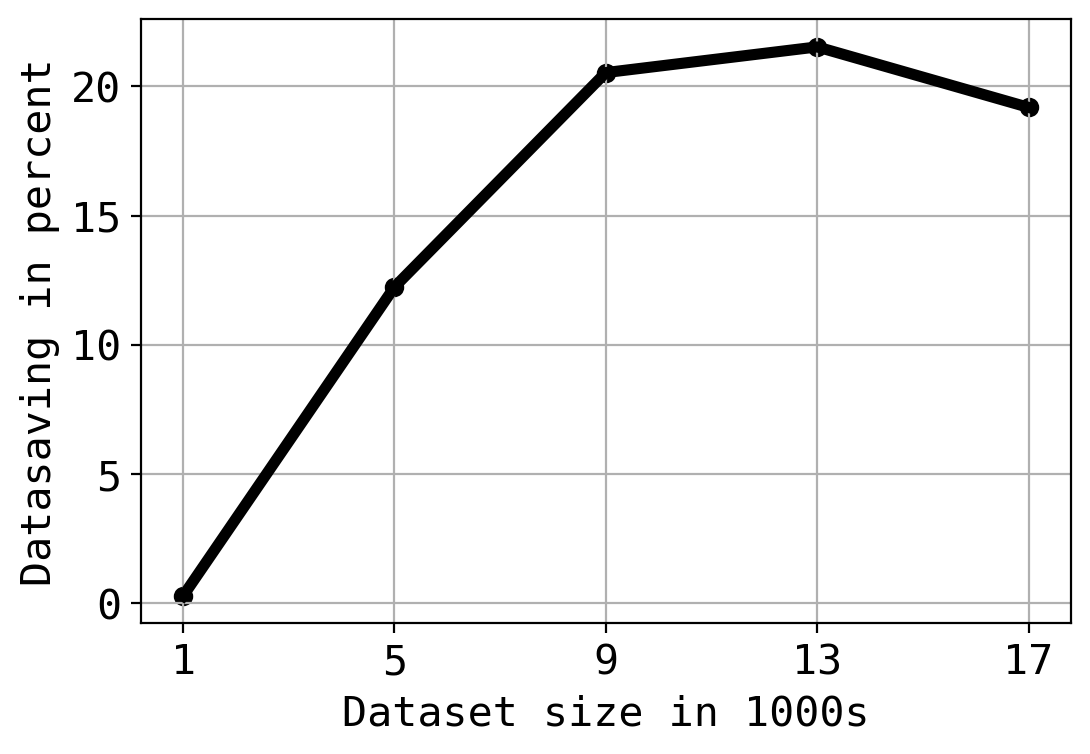

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

def plot_data_savings(strategy_a_file, strategy_d_file, batch_size, percentage=False):
    aa_a = pd.read_csv(strategy_a_file)
    aa_d = pd.read_csv(strategy_d_file)

    set_mpl_params(matplotlib)
    
    labs, labels = get_labels()
    
    means, stds, batch_sizes = get_means_stds_batchsize(aa_a, aa_d)
    print(batch_sizes)
    # print(means[0], means[3], batch_sizes)
    
    coeffs, mean_dict = fit_curve_to_data(means, stds, labels, batch_sizes)
    # print(coeffs)
    data_saving = get_data_savings(mean_dict, coeffs, batch_sizes)
    
    data_saving = np.array(data_saving)
    batch_sizes = np.array(batch_sizes)

    print(data_saving)
    if percentage:
        data_saving = 100 * data_saving / (batch_sizes)
        print(f"batch_sizes used when computing data_saving percent {batch_sizes}")
        print(f"Percentage data saving : {data_saving}")
        
    plt.plot(batch_sizes, data_saving, color="k")
    plt.scatter(batch_sizes, data_saving, color="k")#, label="Datasaving (D vs A) in percent")
    plt.xscale("linear")
    # plt.legend()
    plt.xticks(batch_sizes)
    plt.xlabel("Dataset size in 1000s")
    plt.ylabel("Datasaving in percent")
    plt.grid()
    
    other_configs = (means, stds, labels, coeffs, mean_dict)
    return data_saving, batch_sizes, other_configs
    
os.chdir("/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs")    
plot_data_savings(strategy_a_file = "csv_files/old_csvs/Active_learning_results - AA_A_4k.csv",
                  strategy_d_file = "csv_files/old_csvs/Active_learning_results - AA_D_4k.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc

In [ ]:
plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - QM9_A_EXP.csv",
                  strategy_d_file = "csv_files/Active_learning_results - QM9_D_EXP.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc

[ 0.42048204  1.84002063  4.72486557 10.14536478 20.31025282]


(array([42.04820375, 61.33402094, 67.49807961, 67.63576523, 65.51694459]),
 array([ 1,  3,  7, 15, 31]))

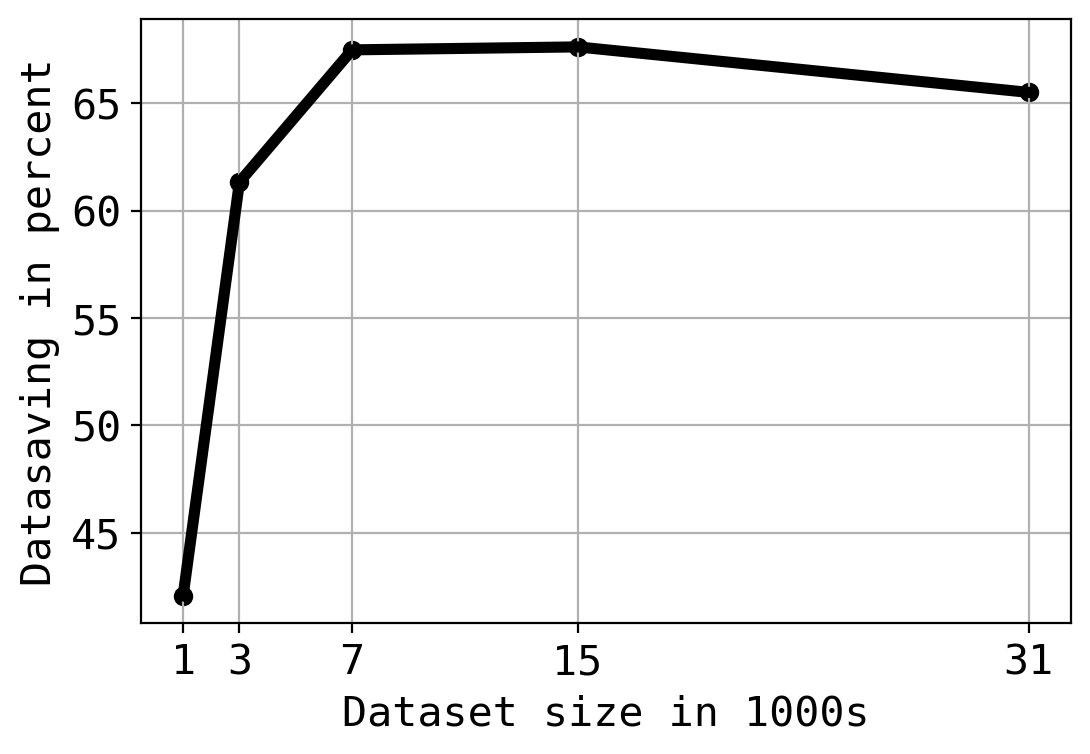

In [50]:
plot_data_savings(strategy_a_file = "csv_files/old_csvs/Active_learning_results - QM9_A_EXP_physdays.csv",
                  strategy_d_file = "csv_files/old_csvs/Active_learning_results - QM9_D_EXP_physdays.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc

[0.01652902 0.51814443 1.94976298 4.52693594 8.4964847 ]


array([ 1,  3,  7, 15, 31])

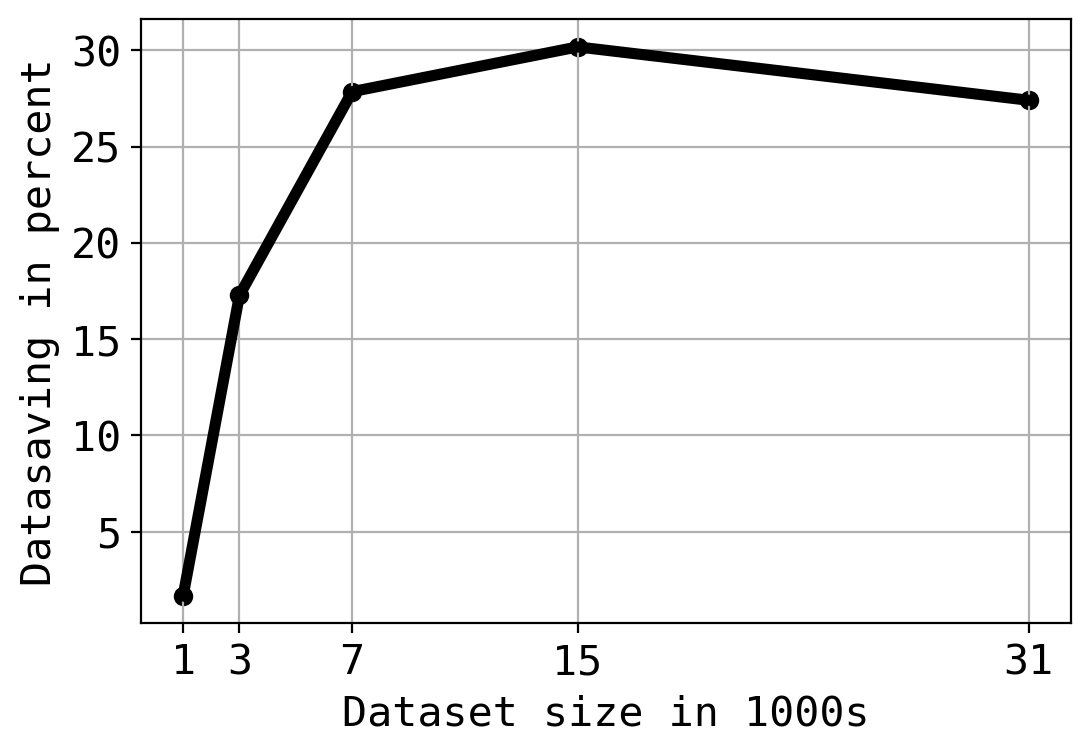

In [51]:
# compute data savings plot for QM9
os.chdir("/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs")    
savings_aa, batch_size_aa = plot_data_savings(strategy_a_file = "csv_files/old_csvs/Active_learning_results - AA_A_EXP_old.csv",
                  strategy_d_file = "csv_files/old_csvs/Active_learning_results - AA_D_EXP_old.csv",
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc
# [ 0.04438062 -0.2239867   0.03023715  0.52630918  0.93471799 -2.68499825]
batch_size_aa

[0.00859015 0.22393374 0.87348482 1.58457138 2.28497207 2.61242363
 2.98994986 3.09844738 3.06580497]


(array([ 0.85901476,  7.46445789, 17.46969645, 22.63673399, 25.38857858,
        23.74930569, 22.99961434, 20.65631587, 18.03414687]),
 array([ 1,  3,  5,  7,  9, 11, 13, 15, 17]))

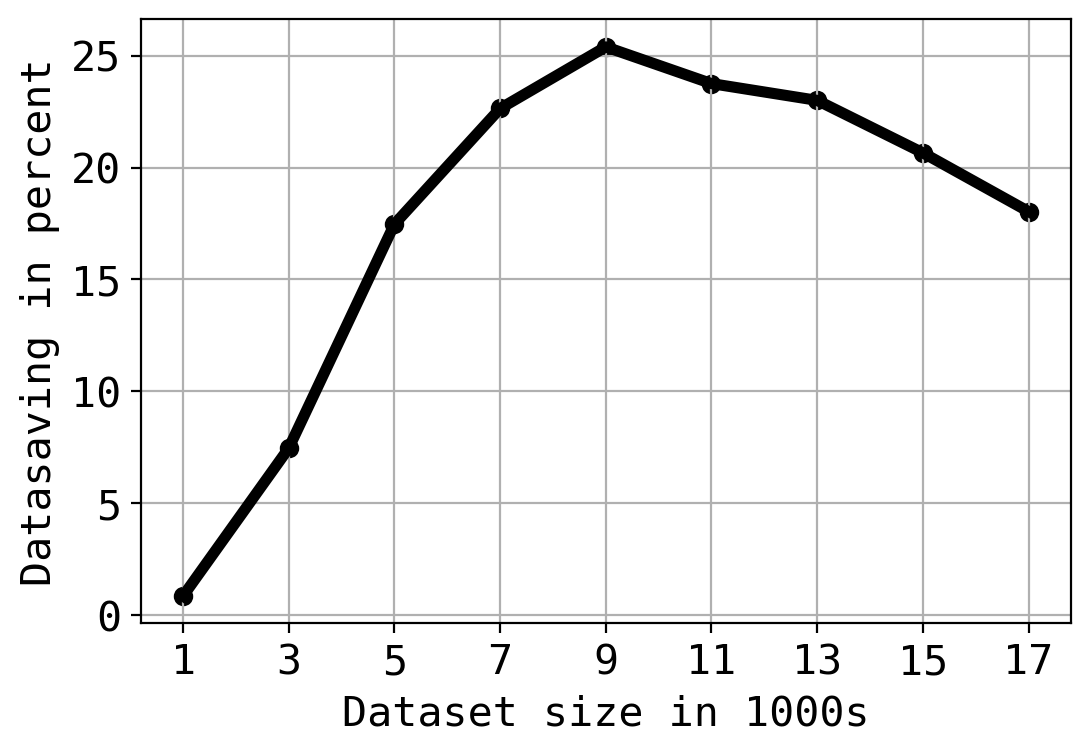

In [52]:
plot_data_savings(strategy_a_file = "csv_files/old_csvs/Active_learning_results - AA_A_2k.csv",
                  strategy_d_file = "csv_files/old_csvs/Active_learning_results - AA_D_2k.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc

[0.04662487 0.10309403 0.36447895 0.57135551 0.8384377  1.1359675
 1.40470688 1.50093146 1.80068159 2.22591367 2.40338128 2.48362159
 2.50240045 2.12099577 2.01583919 1.71845801 1.81789328]


(array([ 4.6624874 ,  5.15470146, 12.1492982 , 14.28388769, 16.76875408,
        18.93279167, 20.06724117, 18.76164319, 20.00757328, 22.25913674,
        21.84892072, 20.69684661, 19.24923425, 15.14996977, 13.4389279 ,
        10.74036258, 10.6934899 ]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]))

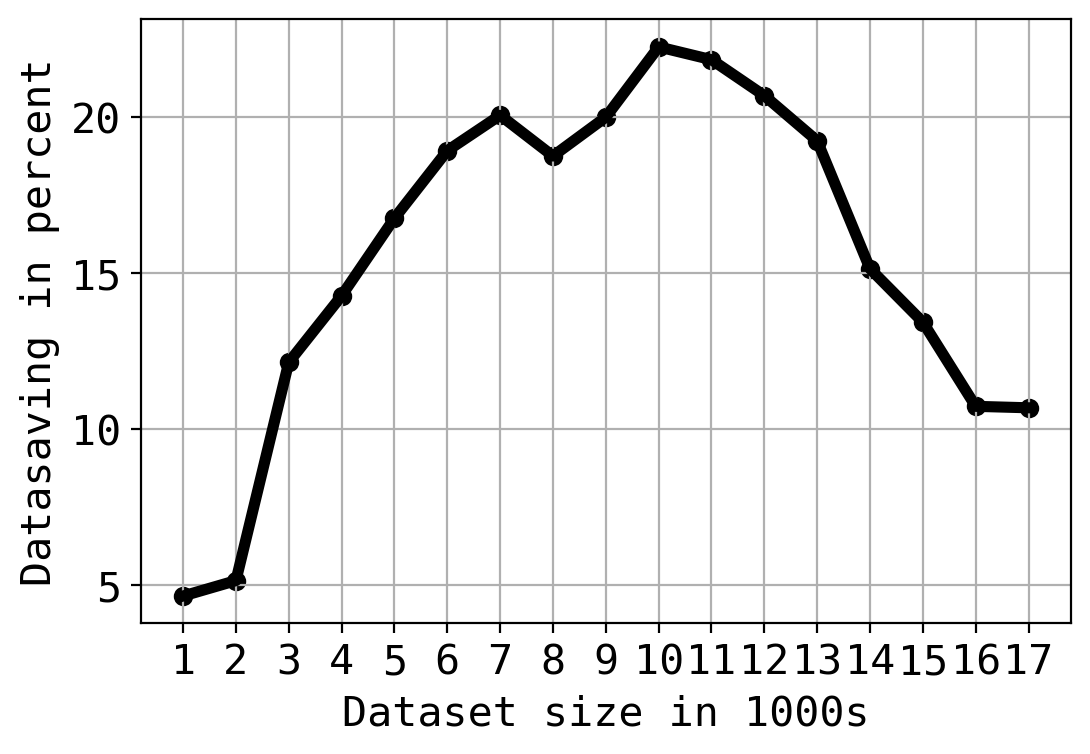

In [53]:
plot_data_savings(strategy_a_file = "csv_files/old_csvs/Active_learning_results - AA_A_1k.csv",
                  strategy_d_file = "csv_files/old_csvs/Active_learning_results - AA_D_1k.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc

[ 0.39477499  1.75762314  4.32339694 10.34945319 21.56542476]


(array([39.47749869, 58.58743787, 61.76281345, 68.99635463, 69.56588632]),
 array([ 1,  3,  7, 15, 31]))

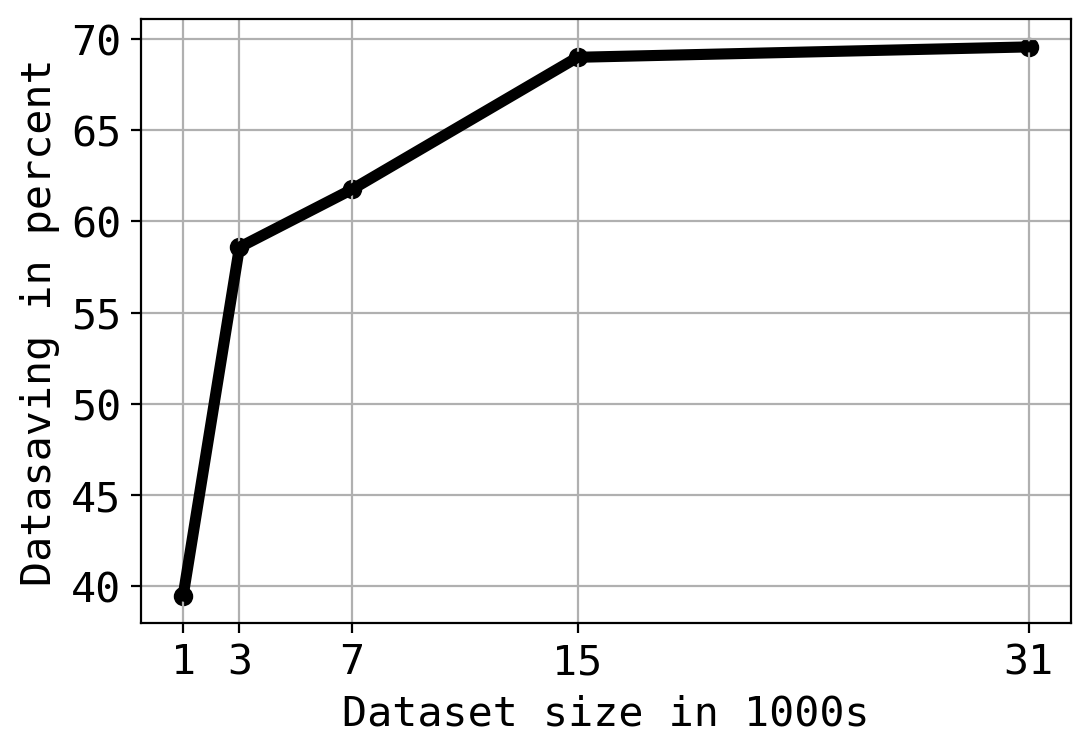

In [54]:
plot_data_savings(strategy_a_file = "csv_files/old_csvs/Active_learning_results - QM9_A_EXP_old.csv",
                  strategy_d_file = "csv_files/old_csvs/Active_learning_results - QM9_D_EXP_old.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc

[ 0.02448883  0.50927786  1.79028363  4.60590983 10.06155717]


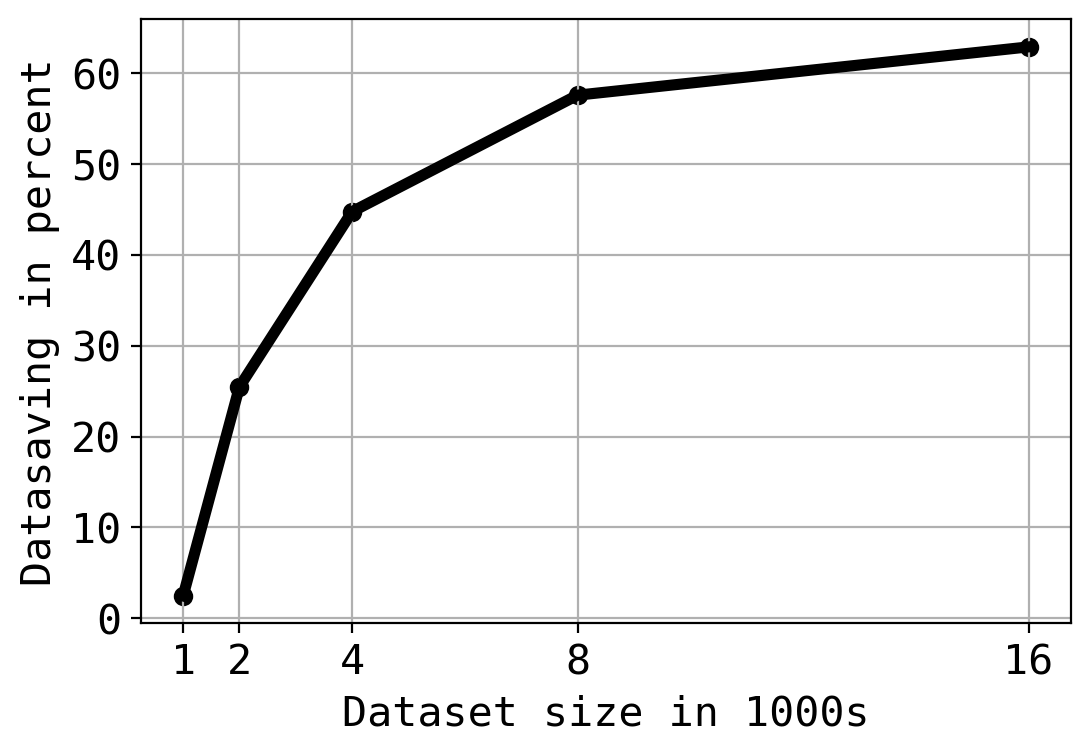

In [55]:
savings_qm9, batch_size_qm9 = plot_data_savings(strategy_a_file = "csv_files/old_csvs/Active_learning_results - QM9_A_EXP.csv",
                  strategy_d_file = "csv_files/old_csvs/Active_learning_results - QM9_D_EXP.csv", 
                  batch_size=None,
                  percentage=True) # 1 for 1k, 2 for 2k etc

[0.03994425 0.58804702 2.03136257 4.36214348 9.54362727]


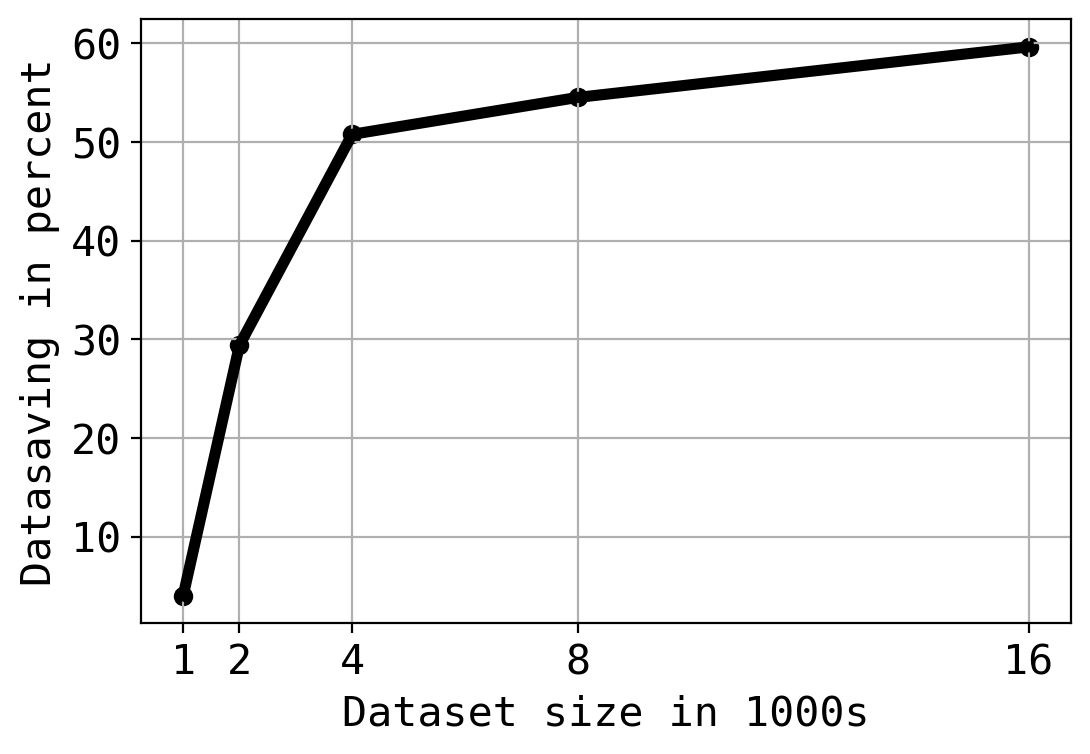

In [56]:
savings_oe, batch_size_oe = plot_data_savings(strategy_a_file = "csv_files/old_csvs/Active_learning_results - OE_A_EXP.csv",
                                                strategy_d_file = "csv_files/old_csvs/Active_learning_results - OE_D_EXP.csv", 
                                                batch_size=None,
                                                percentage=True) # 1 for 1k, 2 for 2k etc

[0.03419867 0.1294239  0.71171404 2.29942212 4.57320267]


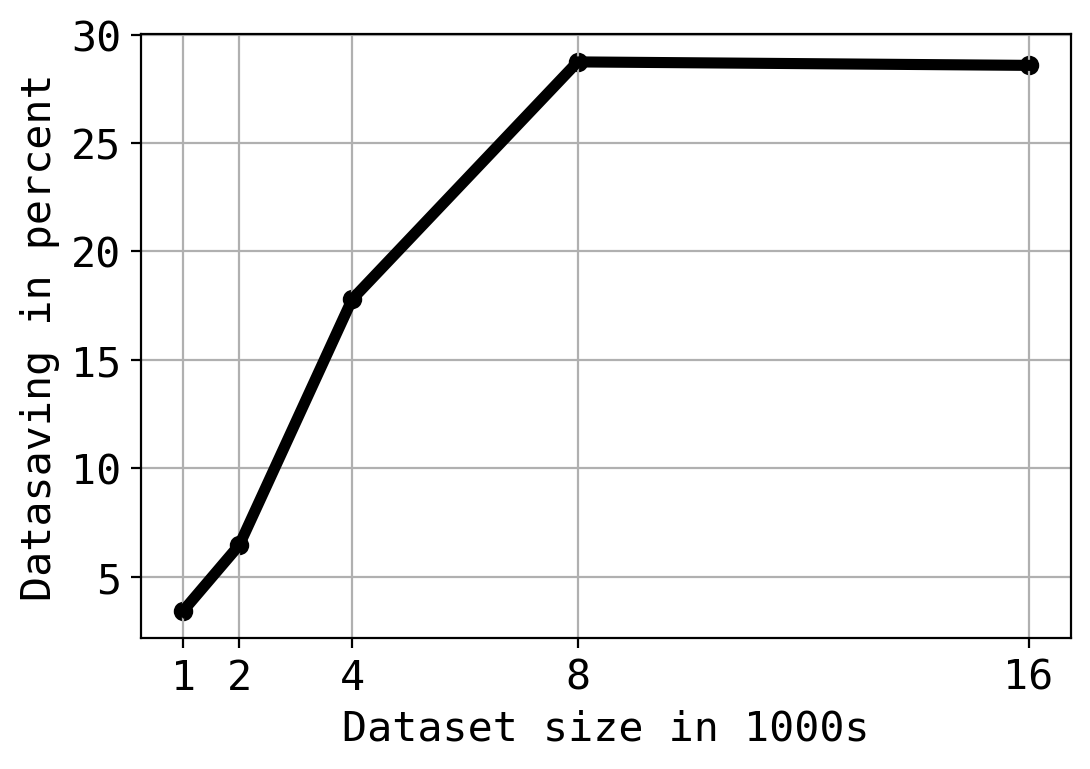

In [57]:
savings_aa, batch_size_aa = plot_data_savings(strategy_a_file = "csv_files/old_csvs/Active_learning_results - AA_A_EXP.csv",
                                                strategy_d_file = "csv_files/old_csvs/Active_learning_results - AA_D_EXP.csv", 
                                                batch_size=None,
                                                percentage=True) # 1 for 1k, 2 for 2k etc

[ 1  2  4  8 16]
rmse 2.1829326931400985e-05
rmse 5.742249198452534e-05
[0.03419867 0.1294239  0.71171404 2.29942212 4.57320267]
batch_sizes used when computing data_saving percent [ 1  2  4  8 16]


Text(0.5, 1.0, 'AA_EXP $ \\alpha = 1e^{-10} $')

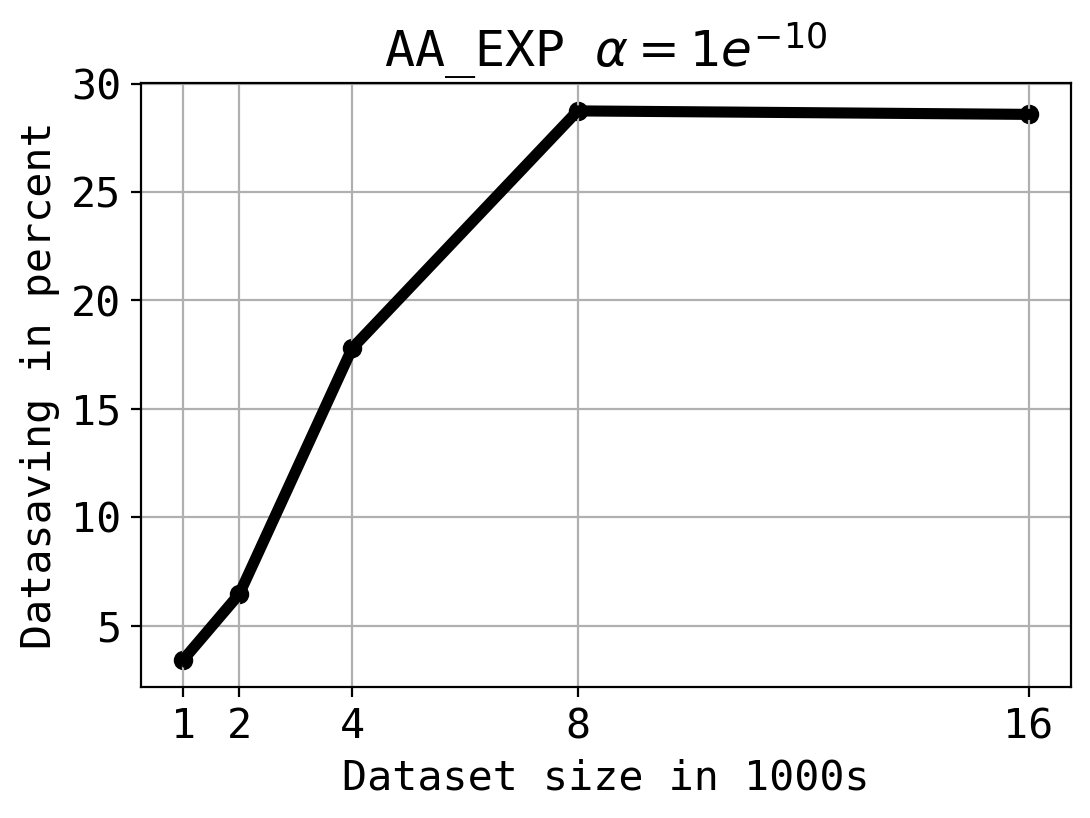

In [22]:
plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_EXP_1e-10.csv",
                  strategy_d_file = "csv_files/Active_learning_results - AA_D_EXP_1e-10.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc
plt.title("AA_EXP $ \\alpha = 1e^{-10} $") 

[ 1  2  4  8 16]
rmse 2.7710422916298984e-05
rmse 6.389538827389945e-05
[0.04288463 0.02452752 0.41486226 1.27271628 0.07310304]
batch_sizes used when computing data_saving percent [ 1  2  4  8 16]
Percentage data saving : [ 4.28846263  1.22637591 10.37155657 15.90895346  0.45689403]
(0.5153933815, 0.5153933815)
(0.3694108515, 0.3534694958)
(0.2775783973, 0.2637276676)
(0.2117793613, 0.2047686009)
(0.1614433127, 0.1602461269)


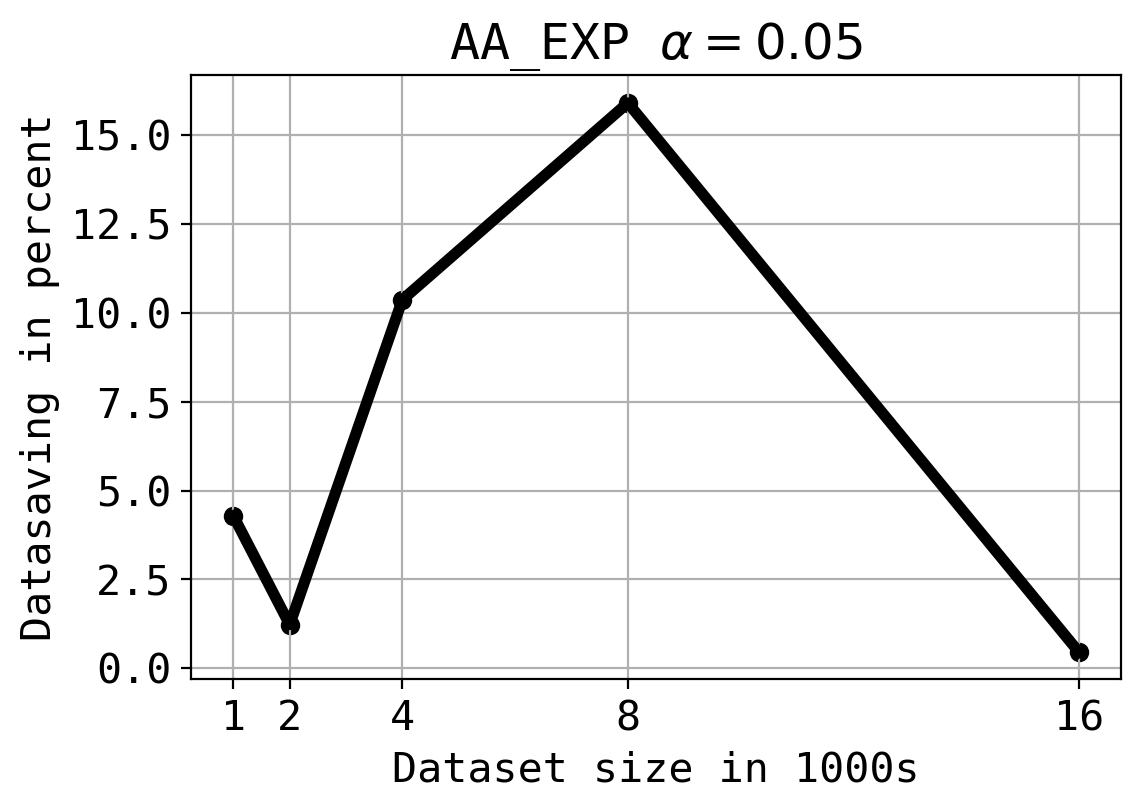

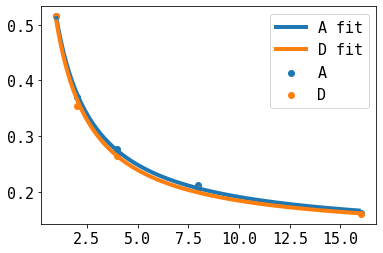

In [52]:
data_saving, batch_sizes, other_configs = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_EXP_0.05.csv",
                  strategy_d_file = "csv_files/Active_learning_results - AA_D_EXP_0.05.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc
plt.title("AA_EXP $ \\alpha = 0.05 $") 

plt.figure()
means, stds, labels, coeffs, mean_dict = other_configs
x = np.arange(1,16,0.1)
plt.plot(x, fx(x, coeffs["A"]), label="A fit")
plt.plot(x, fx(x, coeffs["D"]), label="D fit")
plt.scatter(batch_sizes, mean_dict["A"], label="A")
plt.scatter(batch_sizes, mean_dict["D"], label="D")
for _ in zip(mean_dict["A"], mean_dict["D"]):
    print(_)
plt.legend()



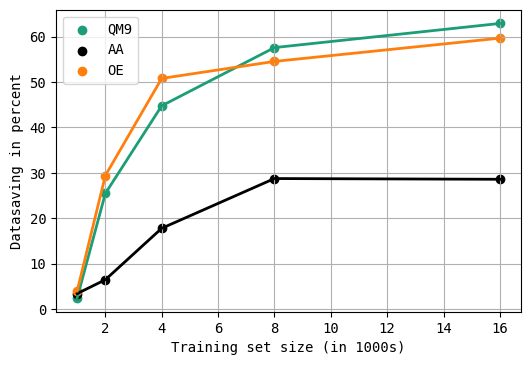

In [59]:
def plot_datasavings_qm9_aa_oe(batch_size_qm9,savings_qm9,batch_size_aa,savings_aa,batch_size_oe,savings_oe):
    set_mpl_params_meeting(matplotlib)
    
    batch_size_qm9 = batch_size_qm9
    savings_qm9 = savings_qm9
    plt.plot(batch_size_qm9, savings_qm9, color="#1b9e77")
    plt.scatter(batch_size_qm9, savings_qm9, color="#1b9e77", label="QM9")

    plt.plot(batch_size_aa, savings_aa, color="k")
    plt.scatter(batch_size_aa, savings_aa, color="k", label="AA")
    
    plt.plot(batch_size_oe, savings_oe, color="tab:orange")
    plt.scatter(batch_size_oe, savings_oe, color="tab:orange", label="OE")

    # plt.xscale("linear")
    plt.legend()
    #plt.xticks(batch_sizes)
    plt.xlabel("Training set size (in 1000s)")
    plt.ylabel("Datasaving in percent")
    plt.grid()
    plt.savefig("DataSavings.png")
    
plot_datasavings_qm9_aa_oe(batch_size_qm9,savings_qm9,batch_size_aa,savings_aa,batch_size_oe,savings_oe)

<Figure size 1200x800 with 0 Axes>

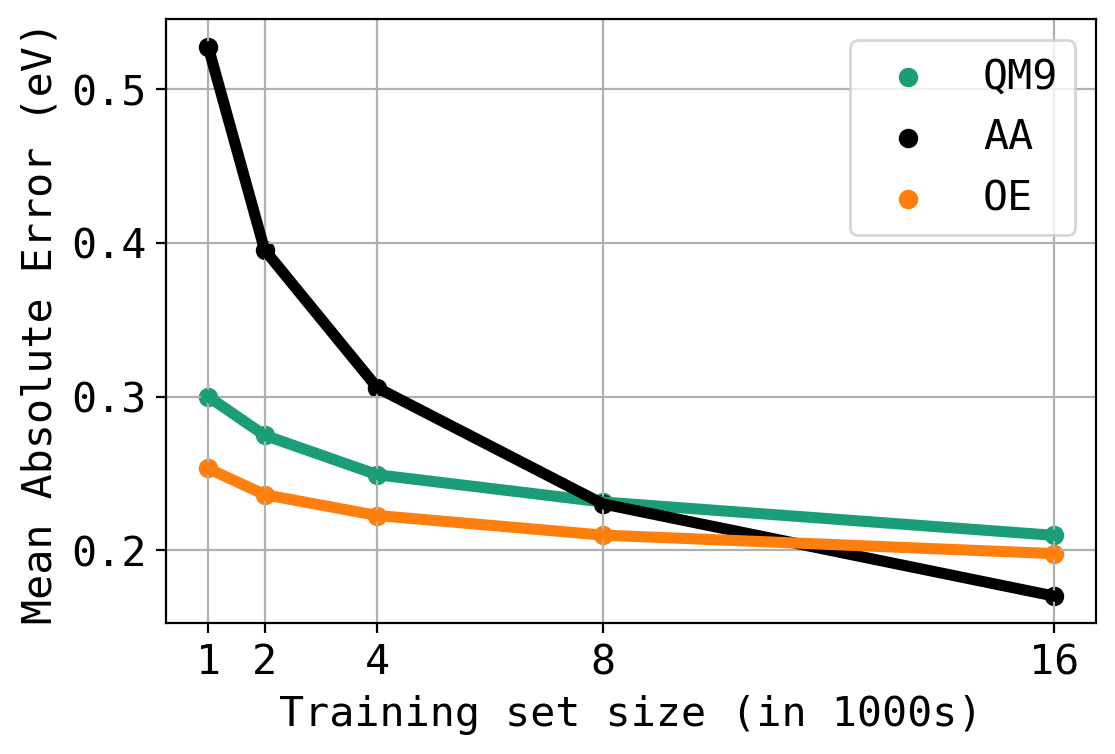

In [60]:
def plot_figure_1(aa, qm9, oe):
    aa_a = pd.read_csv(aa)
    qm9_a = pd.read_csv(qm9)
    oe_a = pd.read_csv(oe)

    set_mpl_params(matplotlib)
    plt.figure(figsize=(6,4), dpi=200)
    labs, labels = get_labels()
    
    batch_size = qm9_a.batch_size // 1000
    
    plt.plot(batch_size, qm9_a.mean_vals.to_numpy(), color="#1b9e77")
    plt.scatter(batch_size, qm9_a.mean_vals.to_numpy(), color="#1b9e77", label="QM9")
    
    plt.plot(batch_size, aa_a.mean_vals.to_numpy(), color="k")
    plt.scatter(batch_size, aa_a.mean_vals.to_numpy(), color="k", label="AA")
    
    plt.plot(batch_size, oe_a.mean_vals.to_numpy(), color="tab:orange")
    plt.scatter(batch_size, oe_a.mean_vals.to_numpy(), color="tab:orange", label="OE")
    
    plt.xticks(batch_size)
    # plt.xscale("linear")
    plt.legend()
    plt.xlabel("Training set size (in 1000s)")
    plt.ylabel("Mean Absolute Error (eV)")
    plt.grid()

plot_figure_1("csv_files/old_csvs/Active_learning_results - AA_A_EXP_old.csv", 
              "csv_files/old_csvs/Active_learning_results - QM9_A_EXP_old.csv",
              "csv_files/old_csvs/Active_learning_results - OE_A_EXP_old.csv")


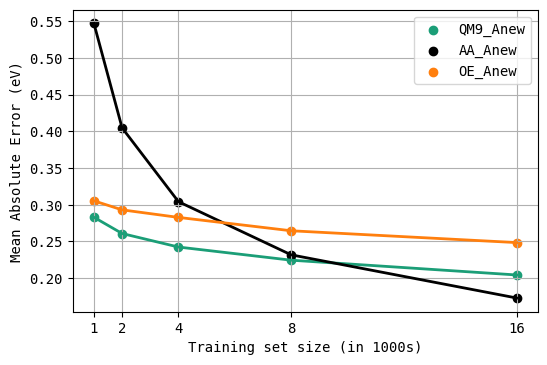

In [275]:
def plot_figure_1(aa, qm9, oe):
    aa_a = pd.read_csv(aa)
    qm9_a = pd.read_csv(qm9)
    oe_a = pd.read_csv(oe)

    set_mpl_params_meeting(matplotlib)
    #plt.figure(figsize=(6,4), dpi=200)
    labs, labels = get_labels()
    
    batch_size = qm9_a.train_size // 1000
    
    plt.plot(batch_size, qm9_a.mean_vals.to_numpy(), color="#1b9e77")
    plt.scatter(batch_size, qm9_a.mean_vals.to_numpy(), color="#1b9e77", label="QM9_Anew")
    
    plt.plot(batch_size, aa_a.mean_vals.to_numpy(), color="k")
    plt.scatter(batch_size, aa_a.mean_vals.to_numpy(), color="k", label="AA_Anew")
    
    plt.plot(batch_size, oe_a.mean_vals.to_numpy(), color="tab:orange")
    plt.scatter(batch_size, oe_a.mean_vals.to_numpy(), color="tab:orange", label="OE_Anew")
    
    plt.xticks(batch_size)
    # plt.xscale("linear")
    plt.legend()
    plt.xlabel("Training set size (in 1000s)")
    plt.ylabel("Mean Absolute Error (eV)")
    plt.grid()

plot_figure_1("csv_files/old_csvs/Active_learning_results - AA_A_EXP.csv", 
              "csv_files/old_csvs/Active_learning_results - QM9_A_EXP.csv",
              "csv_files/old_csvs/Active_learning_results - OE_A_EXP.csv")


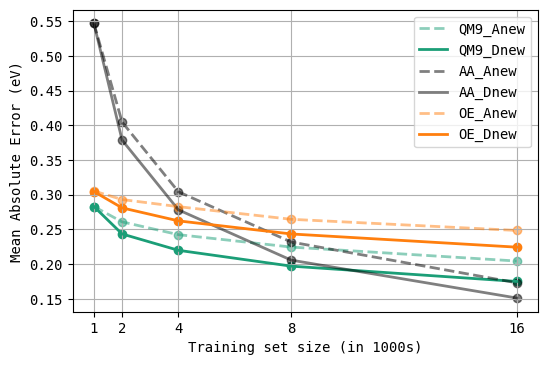

In [11]:
def plot_figure_a_and_d(aa_a, qm9_a, oe_a, aa_d, qm9_d, oe_d):
    aa_a = pd.read_csv(aa_a)
    qm9_a = pd.read_csv(qm9_a)
    oe_a = pd.read_csv(oe_a)
    
    aa_d = pd.read_csv(aa_d)
    qm9_d = pd.read_csv(qm9_d)
    oe_d = pd.read_csv(oe_d)

    set_mpl_params_meeting(matplotlib)
    #plt.figure(figsize=(6,4), dpi=200)
    labs, labels = get_labels()
    
    batch_size = qm9_a.train_size // 1000
    
    plt.plot(batch_size, qm9_a.mean_vals.to_numpy(), "--" , color="#1b9e77", alpha=0.5, label="QM9_Anew")
    plt.scatter(batch_size, qm9_a.mean_vals.to_numpy(), color="#1b9e77", alpha =0.5)
    
    plt.plot(batch_size, qm9_d.mean_vals.to_numpy(), color="#1b9e77", label="QM9_Dnew")
    plt.scatter(batch_size, qm9_d.mean_vals.to_numpy(), color="#1b9e77")
    
    # ------------ AA -------------
    plt.plot(batch_size, aa_a.mean_vals.to_numpy(), "--" , color="k", alpha=0.5, label="AA_Anew")
    plt.scatter(batch_size, aa_a.mean_vals.to_numpy(), color="k", alpha=0.5)
    
    plt.plot(batch_size, aa_d.mean_vals.to_numpy(), color="k", alpha=0.5, label="AA_Dnew")
    plt.scatter(batch_size, aa_d.mean_vals.to_numpy(), color="k", alpha=0.5)
    # ------------ OE -------------
    plt.plot(batch_size, oe_a.mean_vals.to_numpy(), "--" , color="tab:orange", alpha=0.5, label="OE_Anew")
    plt.scatter(batch_size, oe_a.mean_vals.to_numpy(), color="tab:orange", alpha=0.5)
    
    plt.plot(batch_size, oe_d.mean_vals.to_numpy(), color="tab:orange", label="OE_Dnew")
    plt.scatter(batch_size, oe_d.mean_vals.to_numpy(), color="tab:orange")
    
    plt.xticks(batch_size)
    # plt.xscale("linear")
    plt.legend()
    plt.xlabel("Training set size (in 1000s)")
    plt.ylabel("Mean Absolute Error (eV)")
    plt.grid()

plot_figure_a_and_d("csv_files/old_csvs/Active_learning_results - AA_A_EXP.csv", 
              "csv_files/old_csvs/Active_learning_results - QM9_A_EXP.csv",
              "csv_files/old_csvs/Active_learning_results - OE_A_EXP.csv",
              "csv_files/old_csvs/Active_learning_results - AA_D_EXP.csv", 
              "csv_files/old_csvs/Active_learning_results - QM9_D_EXP.csv",
              "csv_files/old_csvs/Active_learning_results - OE_D_EXP.csv")


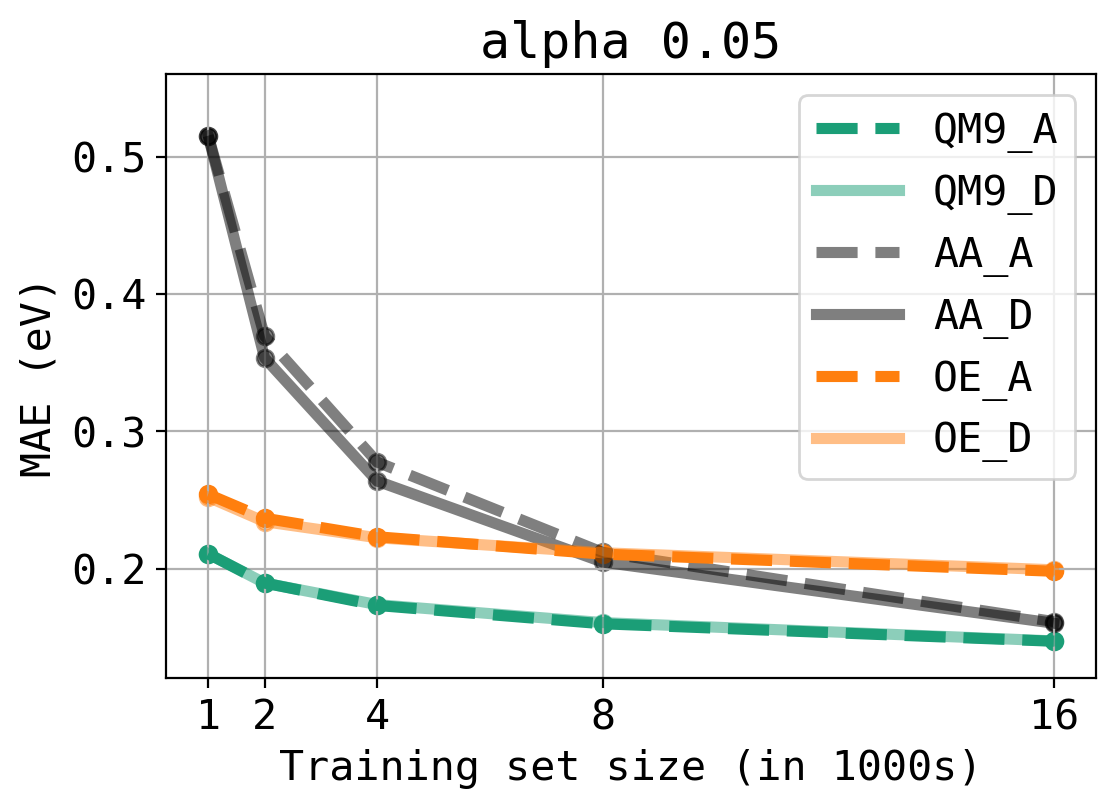

In [5]:
def plot_figure_a_and_d(aa_a, qm9_a, oe_a, aa_d, qm9_d, oe_d):
    aa_a = pd.read_csv(aa_a)[:5]
    qm9_a = pd.read_csv(qm9_a)[:5]
    oe_a = pd.read_csv(oe_a)[:5]
    
    aa_d = pd.read_csv(aa_d)[:5]
    qm9_d = pd.read_csv(qm9_d)[:5]
    oe_d = pd.read_csv(oe_d)[:5]

    set_mpl_params(matplotlib)
    # set_mpl_params_meeting(matplotlib)
    #plt.figure(figsize=(6,4), dpi=200)
    labs, labels = get_labels()
    
    batch_size = qm9_a.train_size // 1000
    
    plt.plot(batch_size, qm9_a.mean_vals.to_numpy(), "--" , color="#1b9e77", alpha=1, label="QM9_A")
    plt.scatter(batch_size, qm9_a.mean_vals.to_numpy(), color="#1b9e77", alpha =1)
    
    plt.plot(batch_size, qm9_d.mean_vals.to_numpy(), color="#1b9e77", alpha=0.5, label="QM9_D")
    plt.scatter(batch_size, qm9_d.mean_vals.to_numpy(), color="#1b9e77", alpha=0.5)
    
    # ------------ AA -------------
    plt.plot(batch_size, aa_a.mean_vals.to_numpy(), "--" , color="k", alpha=0.5, label="AA_A")
    plt.scatter(batch_size, aa_a.mean_vals.to_numpy(), color="k", alpha=0.5)
    
    plt.plot(batch_size, aa_d.mean_vals.to_numpy(), color="k", alpha=0.5, label="AA_D")
    plt.scatter(batch_size, aa_d.mean_vals.to_numpy(), color="k", alpha=0.5)
    # ------------ OE -------------
    plt.plot(batch_size, oe_a.mean_vals.to_numpy(), "--" , color="tab:orange", alpha=1, label="OE_A")
    plt.scatter(batch_size, oe_a.mean_vals.to_numpy(), color="tab:orange", alpha=1)
    
    plt.plot(batch_size, oe_d.mean_vals.to_numpy(), color="tab:orange", alpha=0.5, label="OE_D")
    plt.scatter(batch_size, oe_d.mean_vals.to_numpy(), color="tab:orange", alpha=0.5)
    
    plt.xticks(batch_size)
    # plt.xscale("linear")
    plt.ylim((0.12,0.56))
    plt.legend()
    plt.xlabel("Training set size (in 1000s)")
    plt.ylabel("MAE (eV)")
    plt.title("alpha 0.05")
    plt.grid()

plot_figure_a_and_d("csv_files/Active_learning_results - AA_A_EXP_0.05.csv", 
              "csv_files/Active_learning_results - QM9_A_EXP_0.05.csv",
              "csv_files/Active_learning_results - OE_A_EXP_0.05.csv",
              "csv_files/Active_learning_results - AA_D_EXP_0.05.csv", 
              "csv_files/Active_learning_results - QM9_D_EXP_0.05.csv",
              "csv_files/Active_learning_results - OE_D_EXP_0.05.csv"
                   )

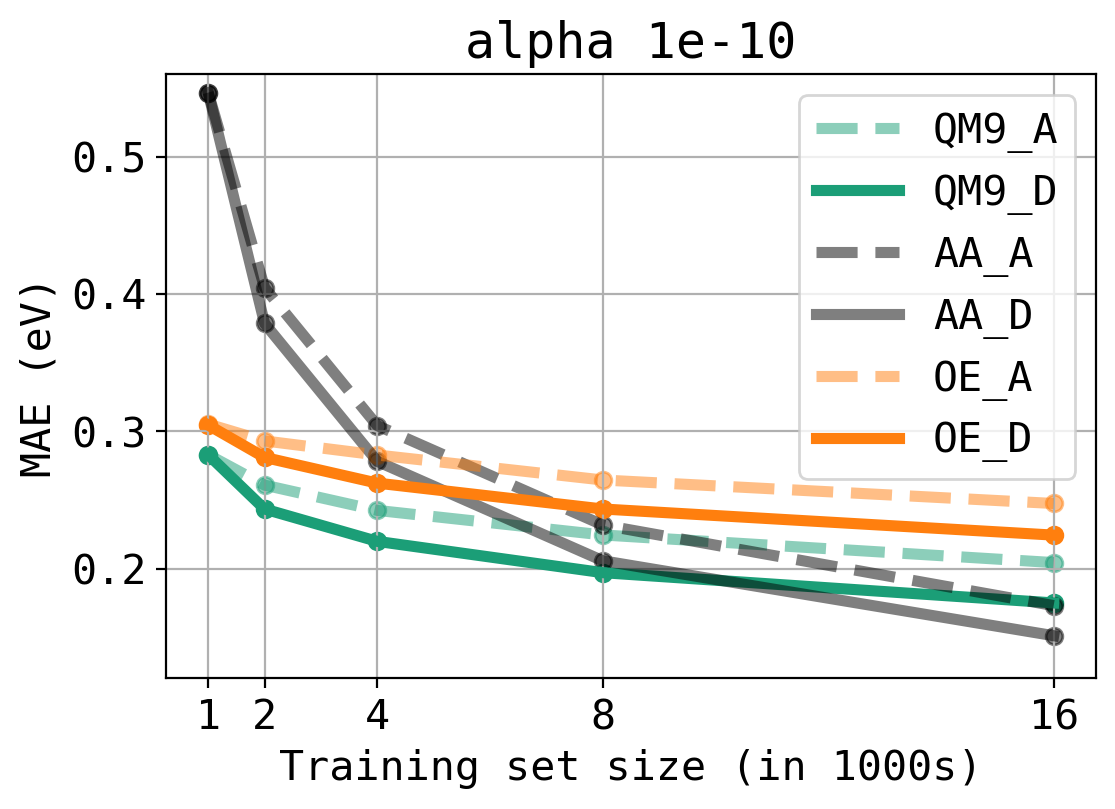

In [7]:
def plot_figure_a_and_d(aa_a, qm9_a, oe_a, aa_d, qm9_d, oe_d):
    aa_a = pd.read_csv(aa_a)[:5]
    qm9_a = pd.read_csv(qm9_a)[:5]
    oe_a = pd.read_csv(oe_a)[:5]
    
    aa_d = pd.read_csv(aa_d)[:5]
    qm9_d = pd.read_csv(qm9_d)[:5]
    oe_d = pd.read_csv(oe_d)[:5]

    set_mpl_params(matplotlib)
    # set_mpl_params_meeting(matplotlib)
    #plt.figure(figsize=(6,4), dpi=200)
    labs, labels = get_labels()
    
    batch_size = qm9_a.train_size // 1000
    
    plt.plot(batch_size, qm9_a.mean_vals.to_numpy(), "--" , color="#1b9e77", alpha=0.5, label="QM9_A")
    plt.scatter(batch_size, qm9_a.mean_vals.to_numpy(), color="#1b9e77", alpha =0.5)
    
    plt.plot(batch_size, qm9_d.mean_vals.to_numpy(), color="#1b9e77", label="QM9_D")
    plt.scatter(batch_size, qm9_d.mean_vals.to_numpy(), color="#1b9e77")
    
    # ------------ AA -------------
    plt.plot(batch_size, aa_a.mean_vals.to_numpy(), "--" , color="k", alpha=0.5, label="AA_A")
    plt.scatter(batch_size, aa_a.mean_vals.to_numpy(), color="k", alpha=0.5)
    
    plt.plot(batch_size, aa_d.mean_vals.to_numpy(), color="k", alpha=0.5, label="AA_D")
    plt.scatter(batch_size, aa_d.mean_vals.to_numpy(), color="k", alpha=0.5)
    # ------------ OE -------------
    plt.plot(batch_size, oe_a.mean_vals.to_numpy(), "--" , color="tab:orange", alpha=0.5, label="OE_A")
    plt.scatter(batch_size, oe_a.mean_vals.to_numpy(), color="tab:orange", alpha=0.5)
    
    plt.plot(batch_size, oe_d.mean_vals.to_numpy(), color="tab:orange", label="OE_D")
    plt.scatter(batch_size, oe_d.mean_vals.to_numpy(), color="tab:orange")
    
    plt.xticks(batch_size)
    # plt.xscale("linear")
    plt.ylim((0.12,0.56))
    plt.legend()
    plt.xlabel("Training set size (in 1000s)")
    plt.ylabel("MAE (eV)")
    plt.title("alpha 1e-10")
    plt.grid()

plot_figure_a_and_d("csv_files/Active_learning_results - AA_A_EXP_1e-10.csv", 
              "csv_files/Active_learning_results - QM9_A_EXP_1e-10.csv",
              "csv_files/Active_learning_results - OE_A_EXP_1e-10.csv",
              "csv_files/Active_learning_results - AA_D_EXP_1e-10.csv", 
              "csv_files/Active_learning_results - QM9_D_EXP_1e-10.csv",
              "csv_files/Active_learning_results - OE_D_EXP_1e-10.csv"
                )

[ 1  2  4  8 16]


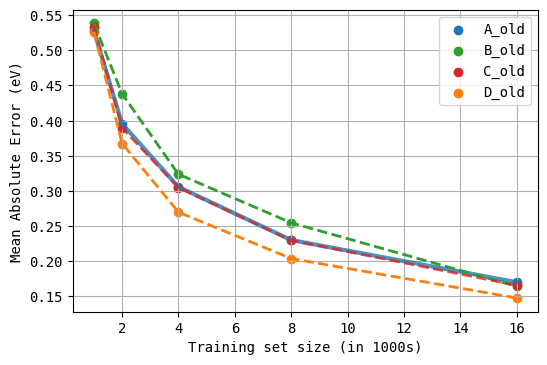

In [210]:
def plot_abcd(lop,lol):
    """
    lop: list of paths (as strings)
    lol: list of labels to be displayed on the plot
    """
    a = pd.read_csv(lop[0])
    b = pd.read_csv(lop[1])
    c = pd.read_csv(lop[2])
    d = pd.read_csv(lop[3])

    set_mpl_params_meeting(matplotlib)
    labs, labels = get_labels()
    
    lines = {"linewidth": 3}
    matplotlib.rc('lines', **lines)
    
    a.mean_vals = np.nan_to_num(a.mean_vals.to_numpy(), nan=0)
    # a_x = np.cumsum(a.batch_size.to_numpy() // 1000) # old/original exp data batch size is training size
    a_x = a.batch_size.to_numpy() // 1000
    plt.plot(a_x, a.mean_vals, color="tab:blue", alpha=0.8)
    plt.scatter(a_x, a.mean_vals, color="tab:blue", label=lol[0])
    
    lines = {"linewidth": 2}
    matplotlib.rc('lines', **lines)
    
    b_x = b.batch_size.to_numpy() // 1000
    plt.plot(b_x, b.mean_vals.to_numpy(), "--",color="tab:green")
    plt.scatter(b_x, b.mean_vals.to_numpy(), color="tab:green", label=lol[1])
    
    c_x = c.batch_size.to_numpy() // 1000
    plt.plot(c_x, c.mean_vals.to_numpy(), "--", color="tab:red", alpha=0.8)
    plt.scatter(c_x, c.mean_vals.to_numpy(), color="tab:red", label=lol[2])
    
    d.mean_vals = np.nan_to_num(d.mean_vals.to_numpy(), nan=0)
    d_x = d.batch_size.to_numpy() // 1000
    plt.plot(d_x, d.mean_vals, "--", color="tab:orange")
    plt.scatter(d_x, d.mean_vals, color="tab:orange", label=lol[3])

    xticks = np.sort(np.unique(np.concatenate([a_x, b_x, c_x, d_x])))
    print(xticks)
    plt.xticks(xticks)
    plt.xscale("linear")
    plt.legend()
    plt.xlabel("Training set size (in 1000s)")
    plt.ylabel("Mean Absolute Error (eV)")
    plt.grid()

list_of_paths = ["csv_files/Active_learning_results - AA_A_EXP_old.csv", 
          "csv_files/Active_learning_results - AA_B_EXP_old.csv",
          "csv_files/Active_learning_results - AA_C_EXP_old.csv",
          "csv_files/Active_learning_results - AA_D_EXP_old.csv"]
list_of_labels = ["A_old","B_old","C_old","D_old"]

plot_abcd(list_of_paths, list_of_labels)  

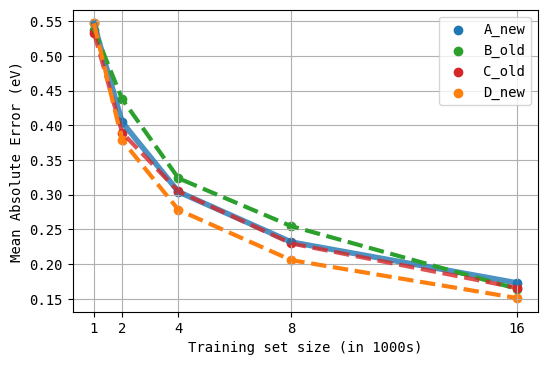

In [16]:
def plot_abcd(lop,lol):
    """
    lop: list of paths (as strings)
    lol: list of labels to be displayed on the plot
    """
    a = pd.read_csv(lop[0])# ; a = a[:-1]
    b = pd.read_csv(lop[1])
    c = pd.read_csv(lop[2])
    d = pd.read_csv(lop[3])# ; d = d[:-1]

    set_mpl_params_meeting(matplotlib)
    # set_mpl_params(matplotlib)
    labs, labels = get_labels()
    
    lines = {"linewidth": 4}
    matplotlib.rc('lines', **lines)
    
    a.mean_vals = np.nan_to_num(a.mean_vals.to_numpy(), nan=0)
    a_x = np.cumsum(a.batch_size.to_numpy() // 1000) # old/original exp data batch size is training size
    # a_x = a.batch_size.to_numpy() // 1000
    plt.plot(a_x, a.mean_vals, color="tab:blue", alpha=0.8)
    plt.scatter(a_x, a.mean_vals, color="tab:blue", label=lol[0])
    
    lines = {"linewidth": 3}
    matplotlib.rc('lines', **lines)
    
    b_x = b.batch_size.to_numpy() // 1000
    plt.plot(b_x, b.mean_vals.to_numpy(), "--", color="tab:green")
    plt.scatter(b_x, b.mean_vals.to_numpy(), color="tab:green", label=lol[1])
    
    c_x = c.batch_size.to_numpy() // 1000
    plt.plot(c_x, c.mean_vals.to_numpy(), "--", color="tab:red", alpha=0.8)
    plt.scatter(c_x, c.mean_vals.to_numpy(), color="tab:red", label=lol[2])
    
    d.mean_vals = np.nan_to_num(d.mean_vals.to_numpy(), nan=0)
    d_x = np.cumsum(d.batch_size.to_numpy() // 1000)
    # d_x = d.batch_size.to_numpy() // 1000
    plt.plot(d_x, d.mean_vals, "--", color="tab:orange")
    plt.scatter(d_x, d.mean_vals, color="tab:orange", label=lol[3])

    xticks = np.sort(np.unique(np.concatenate([a_x, b_x, c_x, d_x])))
    plt.xticks(xticks)
    #plt.xscale("linear")
    plt.legend()
    plt.xlabel("Training set size (in 1000s)")
    plt.ylabel("Mean Absolute Error (eV)")
    plt.grid()

list_of_paths = ["csv_files/old_csvs/Active_learning_results - AA_A_EXP.csv", 
                 "csv_files/old_csvs/Active_learning_results - AA_B_EXP_old.csv",
                 "csv_files/old_csvs/Active_learning_results - AA_C_EXP_old.csv",
                 "csv_files/old_csvs/Active_learning_results - AA_D_EXP.csv"]
list_of_labels = ["A_new","B_old","C_old","D_new"]
# list_of_labels = ["A","B","C","D"]

plot_abcd(list_of_paths, list_of_labels)      

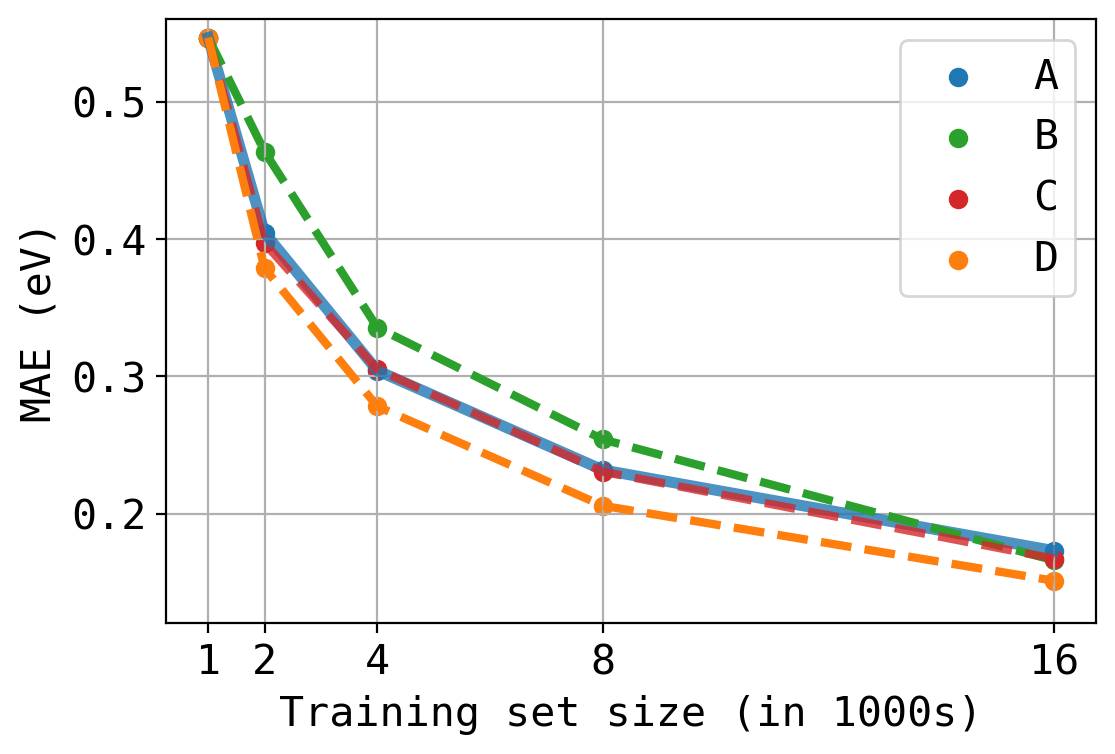

In [20]:
def plot_abcd(lop,lol,loc):
    """
    lop: list of paths (as strings)
    lol: list of labels to be displayed on the plot
    """
    a = pd.read_csv(lop[0])# ; a = a[:-1]
    b = pd.read_csv(lop[1])
    c = pd.read_csv(lop[2])
    d = pd.read_csv(lop[3])# ; d = d[:-1]

    # set_mpl_params_meeting(matplotlib)
    set_mpl_params(matplotlib)
    labs, labels = get_labels()
    
    lines = {"linewidth": 4}
    matplotlib.rc('lines', **lines)
    a_x = a.train_size.to_numpy() // 1000
    plt.plot(a_x, a.mean_vals, color=loc[0], alpha=0.8)
    plt.scatter(a_x, a.mean_vals, color=loc[0], label=lol[0])
    
    lines = {"linewidth": 3}
    matplotlib.rc('lines', **lines)
    
    b_x = b.train_size.to_numpy() // 1000
    plt.plot(b_x, b.mean_vals.to_numpy(), "--", color=loc[1])
    plt.scatter(b_x, b.mean_vals.to_numpy(), color=loc[1], label=lol[1])
    
    c_x = c.train_size.to_numpy() // 1000
    plt.plot(c_x, c.mean_vals.to_numpy(), "--", color=loc[2], alpha=0.8)
    plt.scatter(c_x, c.mean_vals.to_numpy(), color=loc[2], label=lol[2])
    
    d_x = d.train_size.to_numpy() // 1000
    plt.plot(d_x, d.mean_vals, "--", color=loc[3])
    plt.scatter(d_x, d.mean_vals, color=loc[3], label=lol[3])

    xticks = np.sort(np.unique(np.concatenate([a_x, b_x, c_x, d_x])))
    plt.xticks(xticks)
    plt.ylim((0.12,0.56))
    #plt.xscale("linear")
    plt.legend()
    plt.xlabel("Training set size (in 1000s)")
    plt.ylabel("MAE (eV)")
    plt.grid()

list_of_paths = ["csv_files/old_csvs/Active_learning_results - AA_A_EXP.csv", 
                 "csv_files/old_csvs/Active_learning_results - AA_B_EXP.csv",
                 "csv_files/old_csvs/Active_learning_results - AA_C_EXP.csv",
                 "csv_files/old_csvs/Active_learning_results - AA_D_EXP.csv"]
# list_of_labels = ["A_new","B_new","C_new","D_new"]
list_of_labels = ["A","B","C","D"]
list_of_colors = ["tab:blue","tab:green","tab:red","tab:orange"]

plot_abcd(list_of_paths, list_of_labels, list_of_colors)      

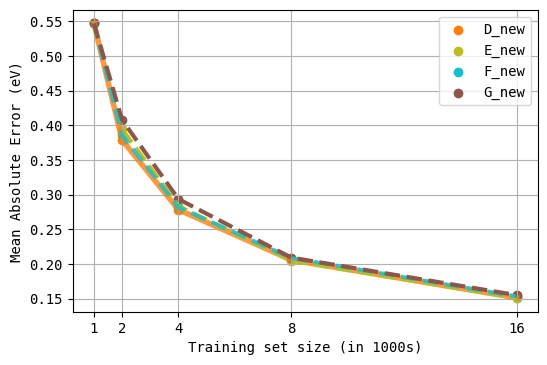

In [92]:
list_of_paths = ["csv_files/Active_learning_results - AA_D_EXP.csv", 
                 "csv_files/Active_learning_results - AA_E_EXP.csv",
                 "csv_files/Active_learning_results - AA_F_EXP.csv",
                 "csv_files/Active_learning_results - AA_G_EXP.csv"]
list_of_labels = ["D_new","E_new","F_new","G_new"]
list_of_colors = ["tab:orange", "tab:olive","tab:cyan","tab:brown"]

plot_abcd(list_of_paths, list_of_labels, list_of_colors) 

# Check if AA A has any effect of batchsize
(Should not have significant effect)

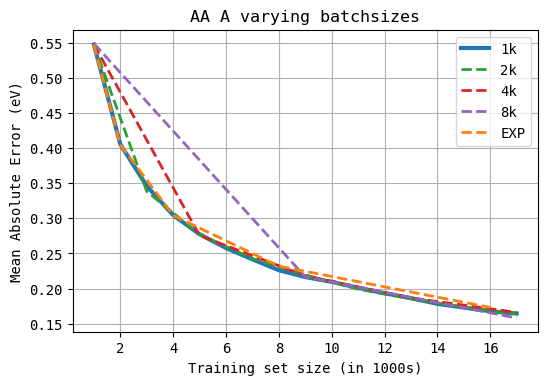

In [250]:
# for aa_a
m1,s1,b1 = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_A_1k.csv"))
m2,s2,b2 = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_A_2k.csv"))
m4,s4,b4 = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_A_4k.csv"))
m8,s8,b8 = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_A_8k.csv"))
me,se,be = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_A_EXP.csv"))

set_mpl_params_meeting(matplotlib)

matplotlib.rc('lines', **{"linewidth": 3}); 
color="tab:blue"; plt.plot(b1, m1, color=color, label="1k"); #plt.scatter(b1, m1, color=color, label="1k")

matplotlib.rc('lines', **{"linewidth": 3})
color="tab:green"; plt.plot(b2, m2, "--", color=color, label="2k"); #plt.scatter(b2, m2, color=color, label="2k")
color="tab:red"; plt.plot(b4, m4, "--", color=color, label="4k"); #plt.scatter(b4, m4, color=color, label="4k")
color="tab:purple"; plt.plot(b8, m8, "--",color=color, label="8k"); #plt.scatter(b8, m8, color=color, label="8k")
color="tab:orange"; plt.plot(be[:-1], me[:-1], "--",color=color, label="EXP"); #plt.scatter(be, me, color=color, label="EXP")
plt.title("AA A varying batchsizes")
plt.xscale("linear")
plt.legend()
plt.xlabel("Training set size (in 1000s)")
plt.ylabel("Mean Absolute Error (eV)")
plt.grid()

# Check if AA D has any effect of batchsize

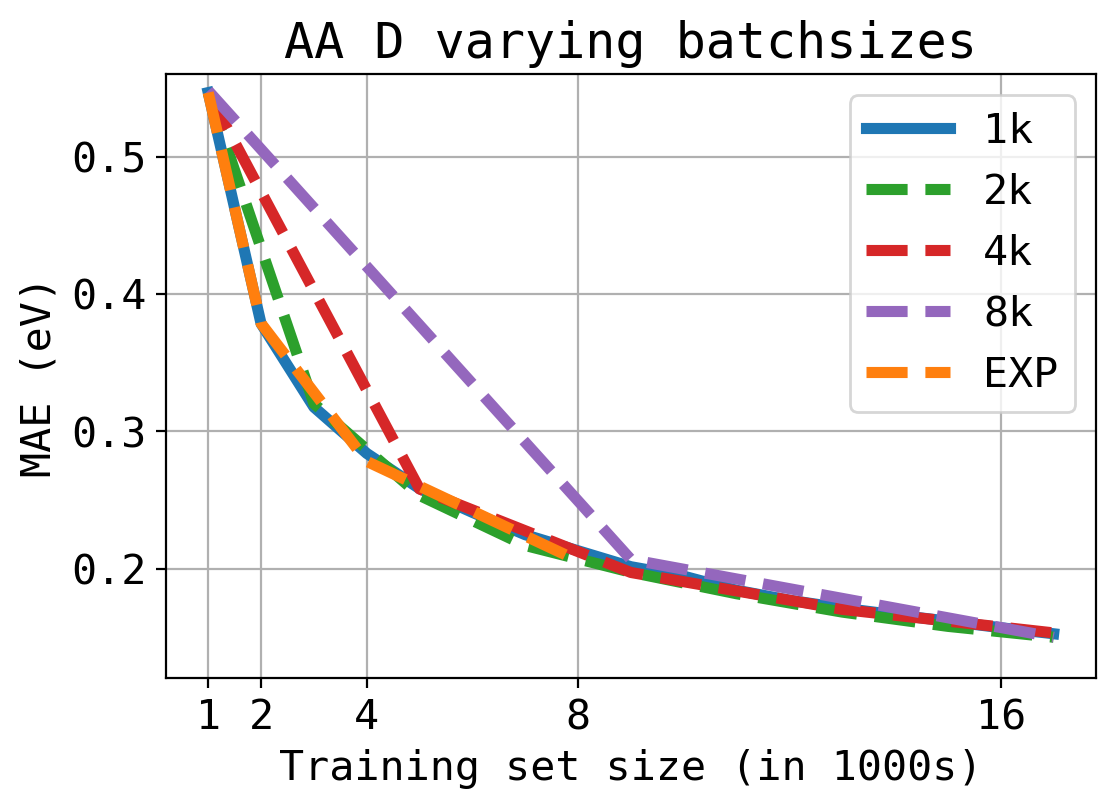

In [18]:
# for aa_d
m1,s1,b1 = get_msb(pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_1k.csv"))
m2,s2,b2 = get_msb(pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_2k.csv"))
m4,s4,b4 = get_msb(pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_4k.csv"))
m8,s8,b8 = get_msb(pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_8k.csv"))
me,se,be = get_msb(pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_EXP.csv"))

# set_mpl_params_meeting(matplotlib)
set_mpl_params(matplotlib)

matplotlib.rc('lines', **{"linewidth": 3}); 
color="tab:blue"; plt.plot(b1, m1, color=color, label="1k"); # plt.scatter(b1, m1, facecolors='none',color=color, label="1k")

matplotlib.rc('lines', **{"linewidth": 3})
color="tab:green"; plt.plot(b2, m2, "--", color=color, label="2k"); #plt.scatter(b2, m2, facecolors='none',color=color, label="2k")
color="tab:red"; plt.plot(b4, m4, "--", color=color, label="4k"); #plt.scatter(b4, m4, facecolors='none',color=color, label="4k")
color="tab:purple"; plt.plot(b8, m8, "--",color=color, label="8k"); #plt.scatter(b8, m8, facecolors='none',color=color, label="8k")
color="tab:orange"; plt.plot(be[:-1], me[:-1], "--",color=color, label="EXP"); #plt.scatter(be, me, facecolors='none',color=color, label="EXP")
plt.title("AA D varying batchsizes")
plt.xscale("linear")
plt.xticks([1,2,4,8,16])
plt.ylim((0.12,0.56))
plt.legend()
plt.xlabel("Training set size (in 1000s)")
plt.ylabel("MAE (eV)")
plt.grid()

# Data savings over batch size

In [252]:
def plot_data_savings_exp(strategy_a_file, strategy_d_file, batch_size, percentage=False):
    aa_a = pd.read_csv(strategy_a_file)[:-1]
    aa_d = pd.read_csv(strategy_d_file)[:-1]

    set_mpl_params(matplotlib)
    
    labs, labels = get_labels()
    
    means, stds, batch_sizes = get_means_stds_batchsize(aa_a, aa_d)
    # print(means[0], means[3], batch_sizes)
    
    coeffs, mean_dict = fit_curve_to_data(means, stds, labels, batch_sizes)
    # print(coeffs)
    data_saving = get_data_savings(mean_dict, coeffs, batch_size, batch_sizes)
    
    data_saving = np.array(data_saving)
    batch_sizes = np.array(batch_sizes)

    print(data_saving)
    if percentage:
        data_saving = 100 * data_saving / (batch_sizes)
        
    plt.plot(batch_sizes, data_saving, color="k")
    plt.scatter(batch_sizes, data_saving, color="k")#, label="Datasaving (D vs A) in percent")
    plt.xscale("linear")
    # plt.legend()
    plt.xticks(batch_sizes)
    plt.xlabel("Dataset size in 1000s")
    plt.ylabel("Datasaving in percent")
    plt.grid()
    return data_saving, batch_sizes

[0.04662487 0.10309403 0.36447895 0.57135551 0.8384377  1.1359675
 1.40470688 1.50093146 1.80068159 2.22591367 2.40338128 2.48362159
 2.50240045 2.12099577 2.01583919 1.71845801 1.81789328]
[0.00859015 0.22393374 0.87348482 1.58457138 2.28497207 2.61242363
 2.98994986 3.09844738 3.06580497]
[2.85367053e-03 6.11982094e-01 1.84837656e+00 2.79905822e+00
 3.26247615e+00]


/users/ghoshkun/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.00370898 0.79323291 1.69877326]
[0.03419867 0.1294239  0.71171404 2.29942212 4.57320267]


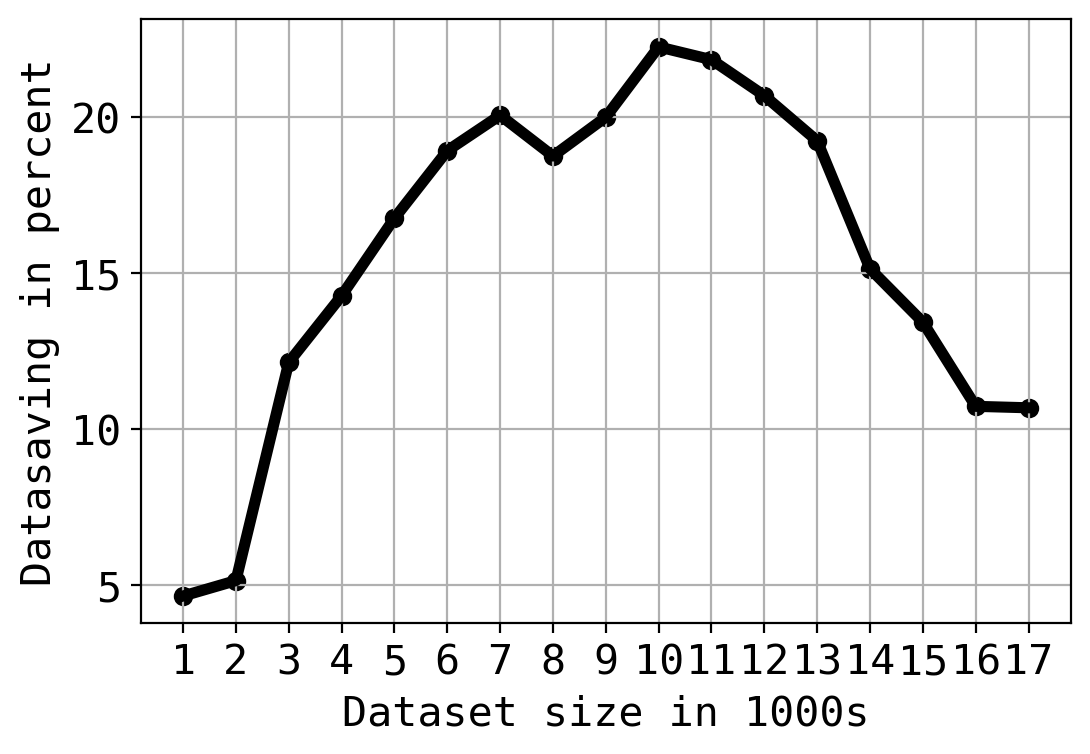

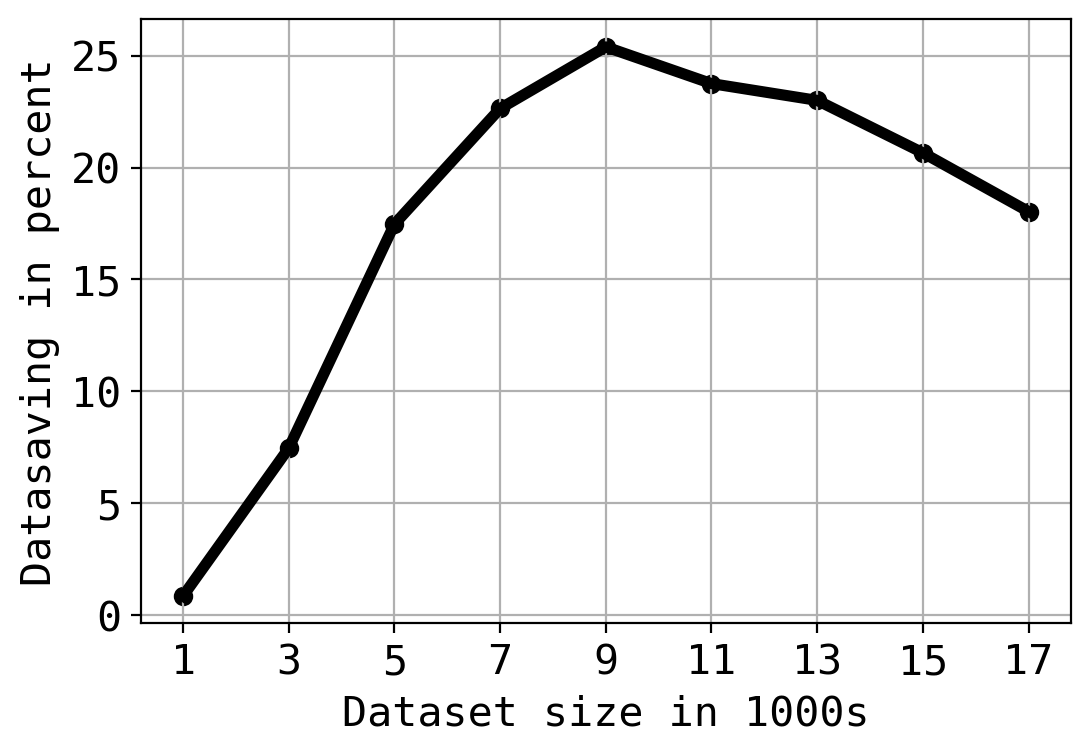

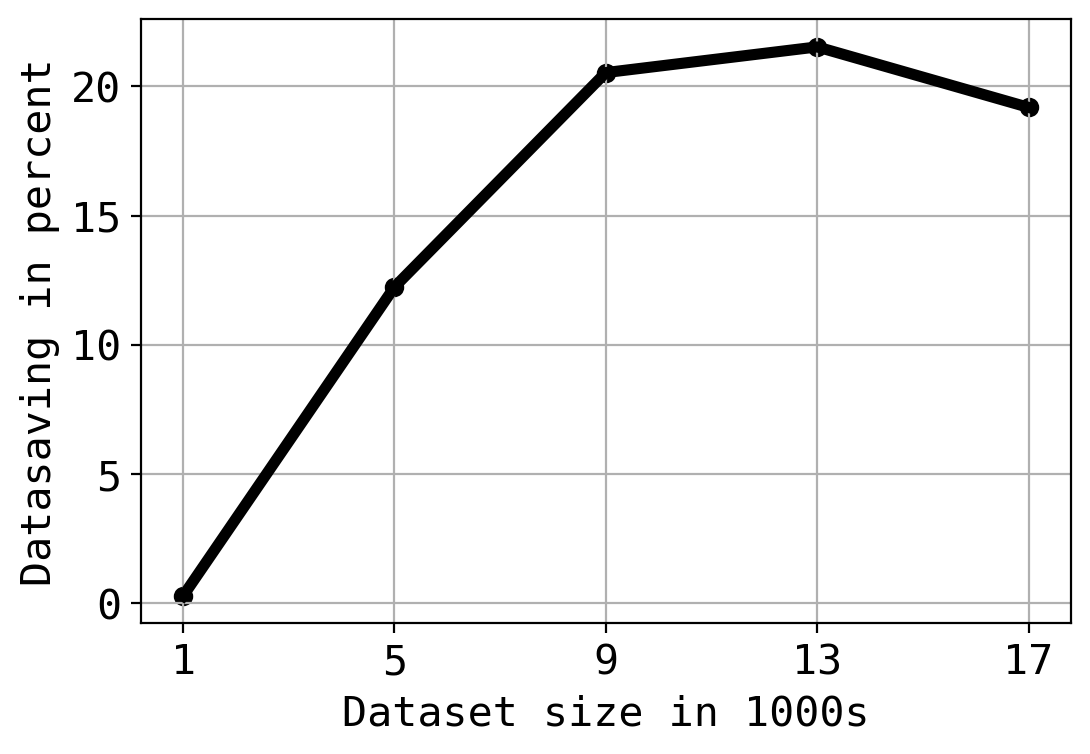

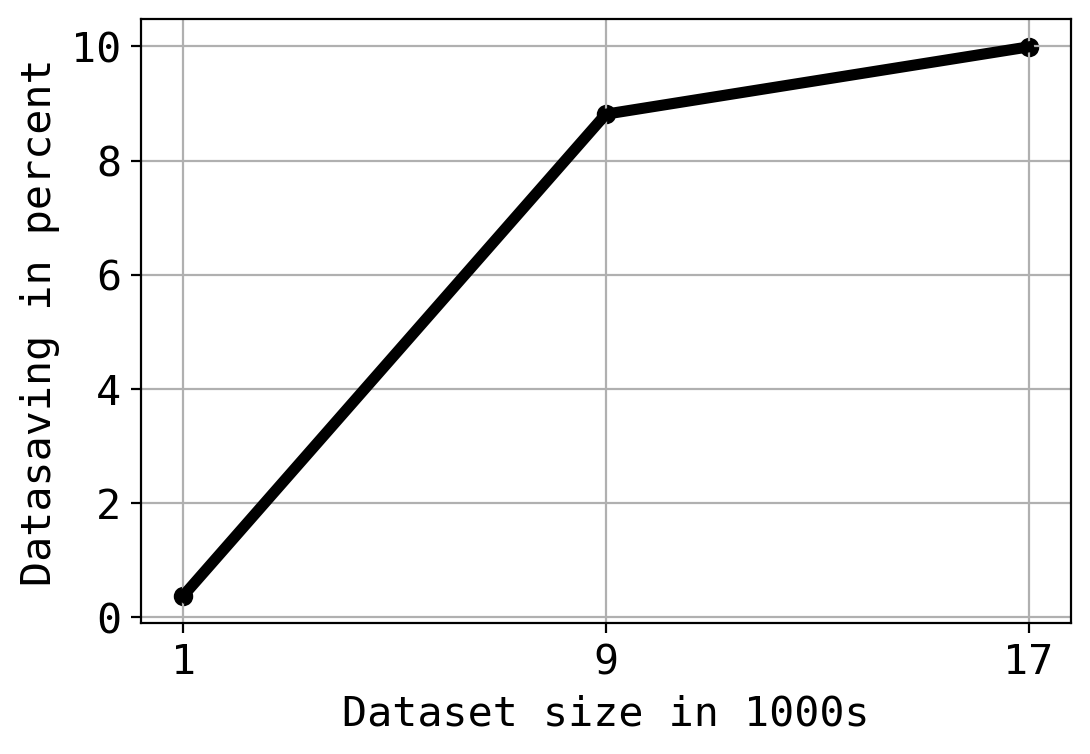

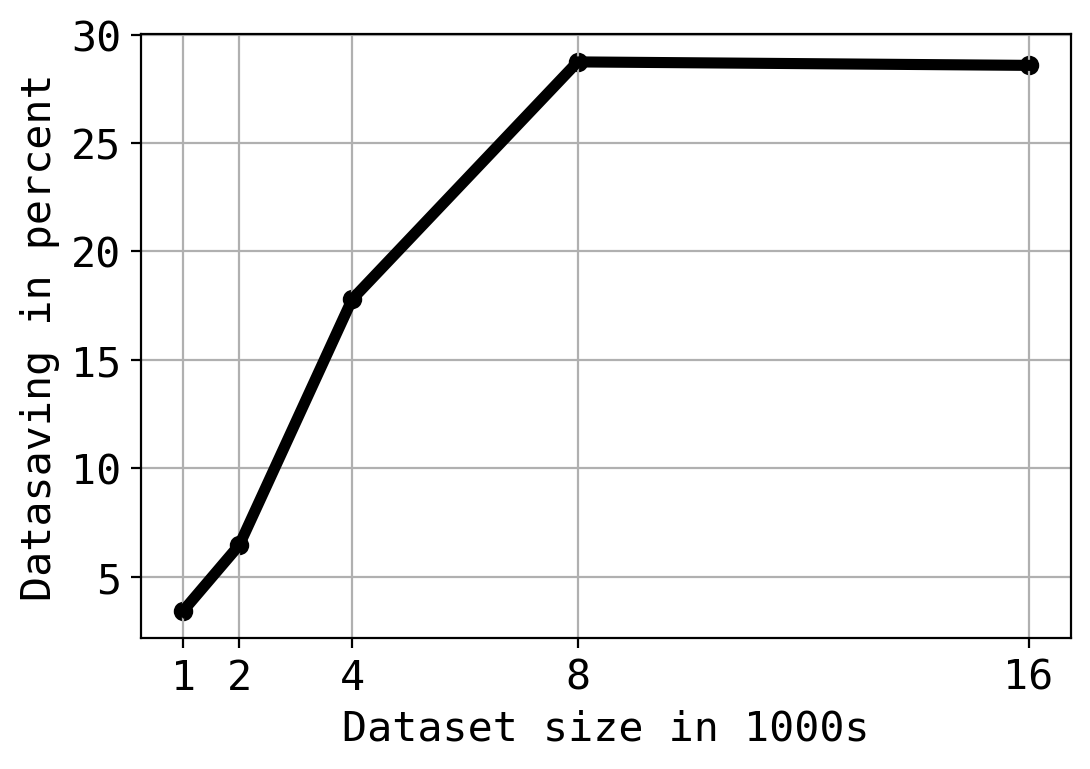

In [253]:
# for aa
%matplotlib agg
s1, b1 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_1k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_1k.csv", batch_size=None, percentage=True) # 1 for 1k, 2 for 2k etc
s2, b2 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_2k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_2k.csv", batch_size=None, percentage=True) # 1 for 1k, 2 for 2k etc
s4, b4 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_4k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_4k.csv", batch_size=None, percentage=True) # 1 for 1k, 2 for 2k etc
s8, b8 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_8k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_8k.csv", batch_size=None, percentage=True) # 1 for 1k, 2 for 2k etc
se, be = plot_data_savings_exp(strategy_a_file = "csv_files/Active_learning_results - AA_A_EXP.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_EXP.csv", batch_size=None, percentage=True) # 1 for 1k, 2 for 2k etc

In [256]:
se

array([ 3.41986698,  6.47119518, 17.79285091, 28.74277645, 28.58251666])

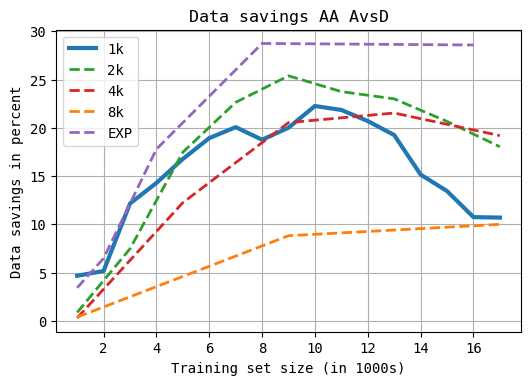

In [257]:
set_mpl_params_meeting(matplotlib)

matplotlib.rc('lines', **{"linewidth": 3}); 
color="tab:blue"; plt.plot(b1, s1, color=color, label="1k"); #plt.scatter(b1, m1, color=color, label="1k")

matplotlib.rc('lines', **{"linewidth": 2})
color="tab:green"; plt.plot(b2, s2, "--", color=color, label="2k"); #plt.scatter(b2, m2, color=color, label="2k")
color="tab:red"; plt.plot(b4, s4, "--", color=color, label="4k"); #plt.scatter(b4, m4, color=color, label="4k")
color="tab:orange"; plt.plot(b8, s8, "--",color=color, label="8k"); #plt.scatter(b8, m8, color=color, label="8k")
color="tab:purple"; plt.plot(be, se, "--",color=color, label="EXP"); #plt.scatter(be, me, color=color, label="EXP")
plt.title("Data savings AA AvsD")
plt.xscale("linear")
plt.legend()
plt.xlabel("Training set size (in 1000s)")
plt.ylabel("Data savings in percent")
plt.grid()

# Data savings absolute value

[0.04662487 0.10309403 0.36447895 0.57135551 0.8384377  1.1359675
 1.40470688 1.50093146 1.80068159 2.22591367 2.40338128 2.48362159
 2.50240045 2.12099577 2.01583919 1.71845801 1.81789328]
[0.00859015 0.22393374 0.87348482 1.58457138 2.28497207 2.61242363
 2.98994986 3.09844738 3.06580497]
[2.85367053e-03 6.11982094e-01 1.84837656e+00 2.79905822e+00
 3.26247615e+00]


/users/ghoshkun/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.00370898 0.79323291 1.69877326]
[0.03419867 0.1294239  0.71171404 2.29942212 4.57320267]


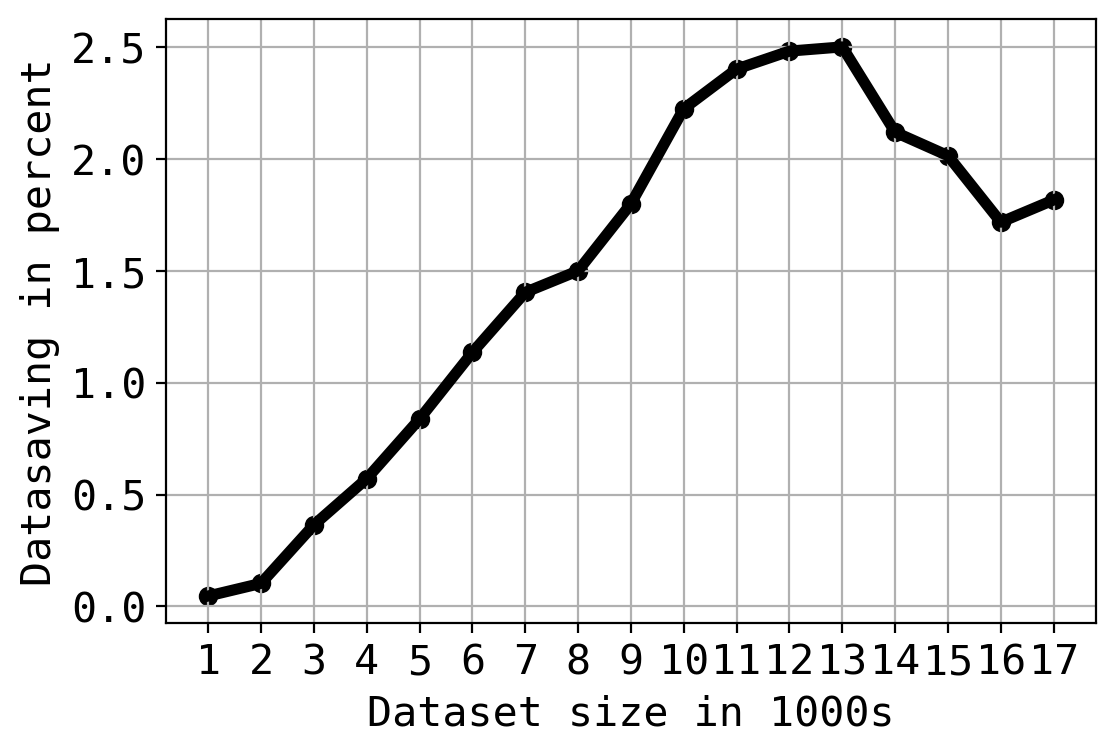

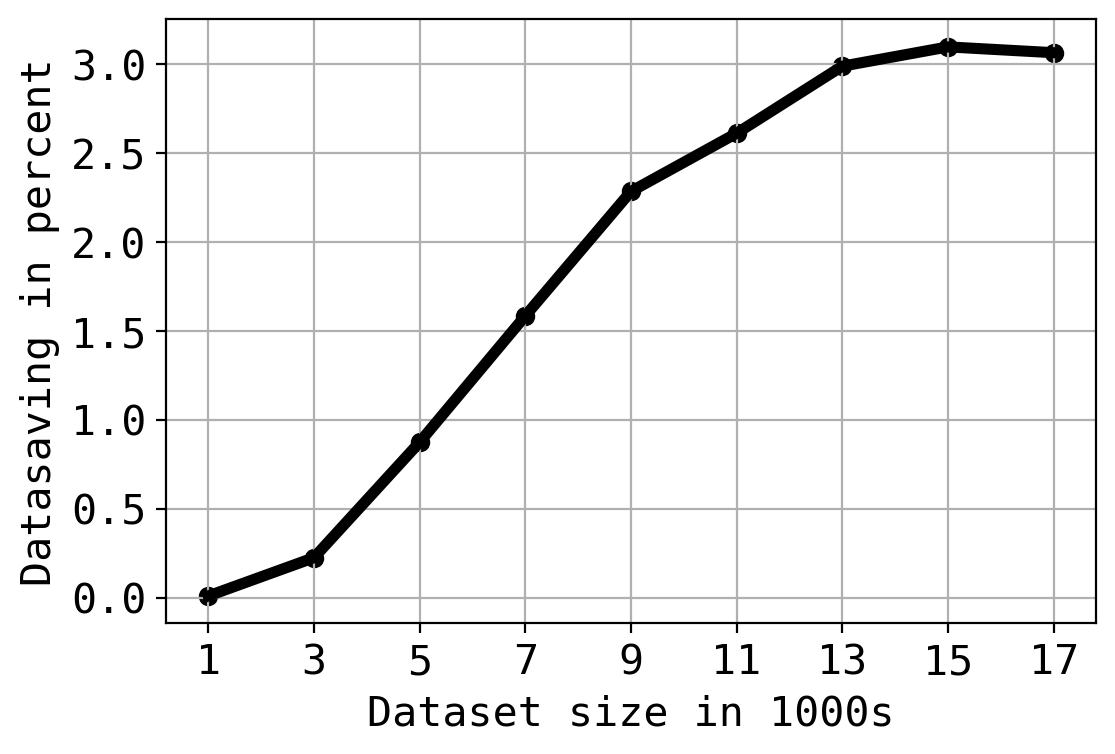

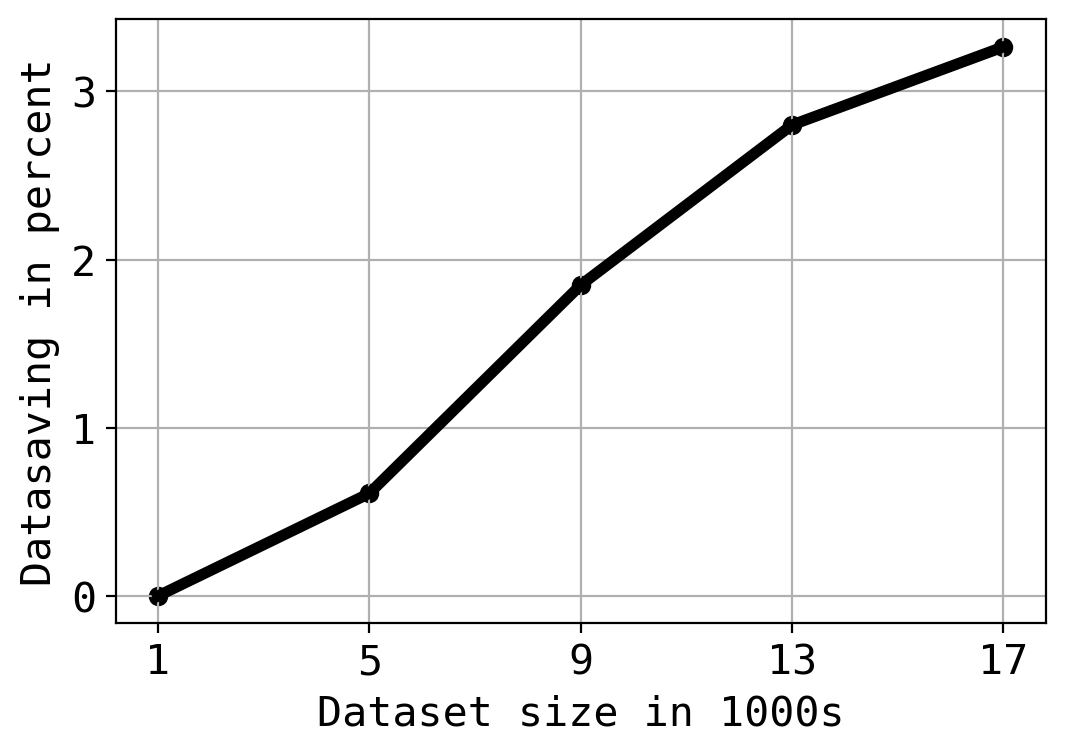

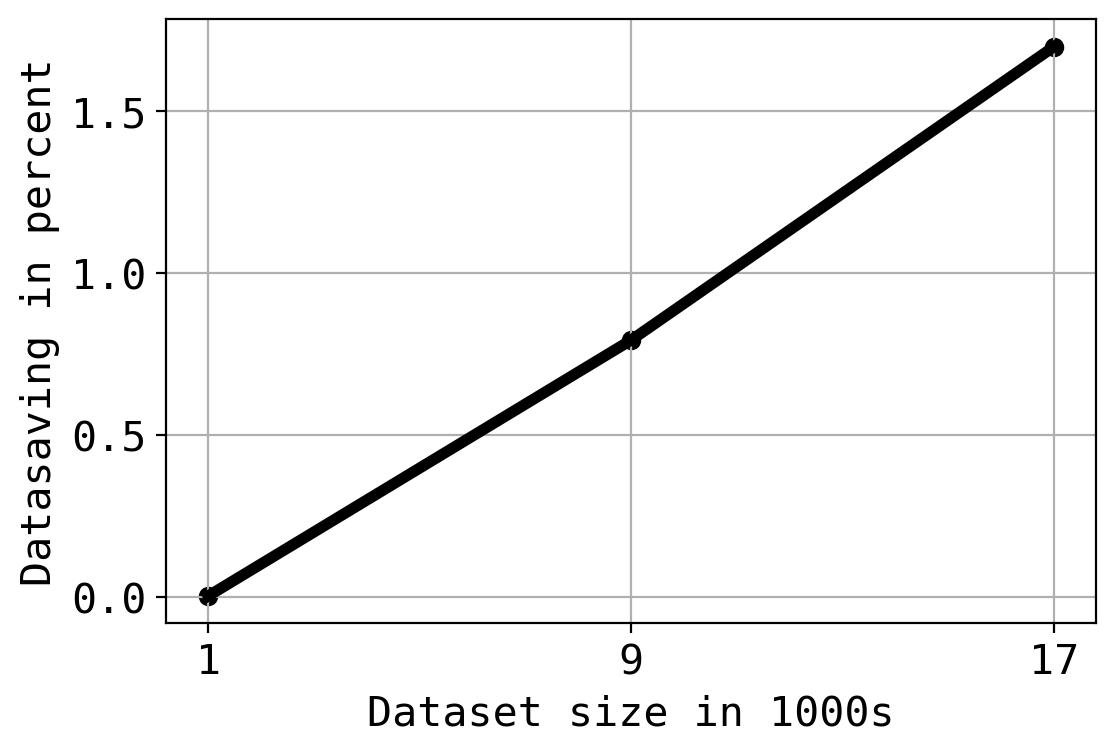

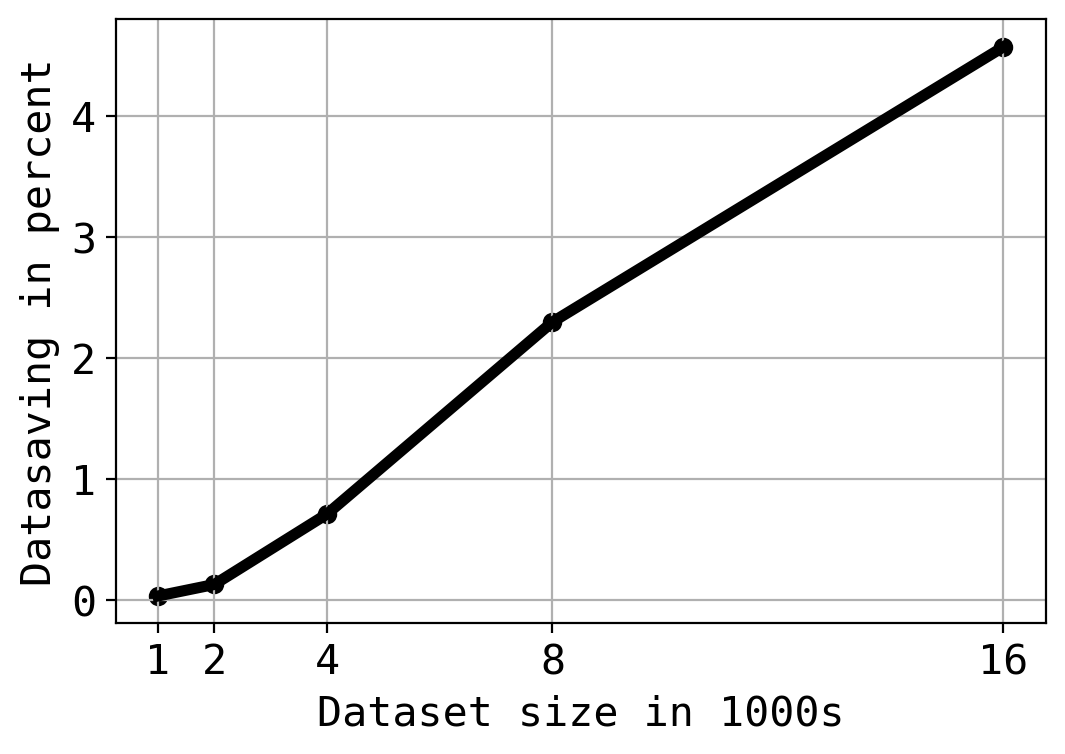

In [258]:
# for aa
%matplotlib agg
s1, b1 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_1k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_1k.csv", batch_size=None, percentage=False) # 1 for 1k, 2 for 2k etc
s2, b2 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_2k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_2k.csv", batch_size=None, percentage=False) # 1 for 1k, 2 for 2k etc
s4, b4 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_4k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_4k.csv", batch_size=None, percentage=False) # 1 for 1k, 2 for 2k etc
s8, b8 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_8k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_8k.csv", batch_size=None, percentage=False) # 1 for 1k, 2 for 2k etc
se, be = plot_data_savings_exp(strategy_a_file = "csv_files/Active_learning_results - AA_A_EXP.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_EXP.csv", batch_size=None, percentage=False) # 1 for 1k, 2 for 2k etc

In [262]:
se

array([0.03419867, 0.1294239 , 0.71171404, 2.29942212, 4.57320267])

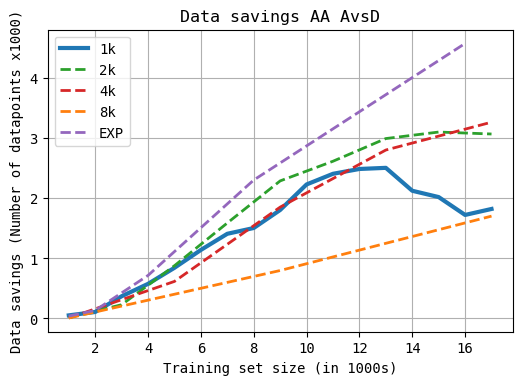

In [263]:
set_mpl_params_meeting(matplotlib)

matplotlib.rc('lines', **{"linewidth": 3}); 
color="tab:blue"; plt.plot(b1, s1, color=color, label="1k"); #plt.scatter(b1, m1, color=color, label="1k")

matplotlib.rc('lines', **{"linewidth": 2})
color="tab:green"; plt.plot(b2, s2, "--", color=color, label="2k"); #plt.scatter(b2, m2, color=color, label="2k")
color="tab:red"; plt.plot(b4, s4, "--", color=color, label="4k"); #plt.scatter(b4, m4, color=color, label="4k")
color="tab:orange"; plt.plot(b8, s8, "--",color=color, label="8k"); #plt.scatter(b8, m8, color=color, label="8k")
color="tab:purple"; plt.plot(be, se, "--",color=color, label="EXP"); #plt.scatter(be, me, color=color, label="EXP")
plt.title("Data savings AA AvsD")
plt.xscale("linear")
plt.legend()
plt.xlabel("Training set size (in 1000s)")
plt.ylabel("Data savings (Number of datapoints x1000)") # how many fewer datapoints does D require to get same MAE
plt.grid()

# Compute data savings by fitting only to AA_A_1k 
Since the batch size doesn't really matter, so we use the one with the highest resolution

[1.         0.83723508 0.97985789 0.09178411]


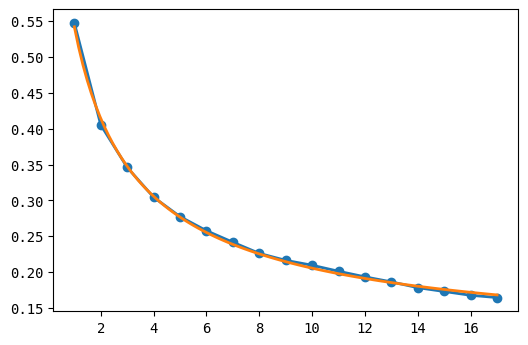

In [62]:
set_mpl_params_meeting(matplotlib)
# get parameters after fitting to AA_A_1k
def get_aa_a_1k_params(batch_sizes, mean):
    results = curve_fit(lambda x,a,b,c,d: d + (a-d)/(1 + (x/c)**b), batch_sizes, mean, p0=[0.5, 0.5, 0.5, 0.5], bounds=(-1, [1., 1., 2, 2]), maxfev=10000)
    # results = curve_fit(lambda x,a,b,c: -a*np.log(x**b)+c, batch_sizes, mean, p0=[0.7, 2, 0.5], bounds=(0, [1., 3., 0.6]), maxfev=1000)
    return(results[0]) # returns (a,b,c,d) # y = d + (a-d)/(1 + (x/c)**b)

aa_a = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_A_1k.csv")
plt.plot(aa_a.train_size//1000, aa_a.mean_vals)
plt.scatter(aa_a.train_size//1000, aa_a.mean_vals)
# plt.xscale("log")
fit_params = get_aa_a_1k_params(aa_a.train_size//1000, aa_a.mean_vals)
print(fit_params)
a,b,c,d = fit_params
x = np.linspace(1,17,100)
plt.plot(x, d + (a-d)/(1 + (x/c)**b))

In [64]:
# set_mpl_params_meeting(matplotlib)

# plt.plot(aa_a.train_size//1000, aa_a.mean_vals)
# plt.scatter(aa_a.train_size//1000, aa_a.mean_vals)
# print(fit_params)
# a,b,c = fit_params
# x = np.linspace(1,17,100)
# plt.plot(x, -a*np.log(x**b)+c)

# Fitting using a simple hyperbolic function

In [69]:
from scipy.optimize import minimize
def scipy_fit(batch_sizes, mean):
    def fx(args):
        a,b,c,d = args
        x = np.array(batch_sizes)
        predict = -a + c/x**b# -a*np.log(x**b)+d # -a*np.log(x**b)+c*x+d
        true = mean
        error = np.mean((predict - mean)**2)
        return error
    params = minimize(fx, (0.7, 2, 0.55,0.5))
    return(params) # returns (a,b,c,d) # y = d + (a-d)/(1 + (x/c)**b)

fit = scipy_fit(aa_a.train_size//1000, aa_a.mean_vals)
fit_params = fit.x

[0.00412327 0.41600121 0.55037837 0.5       ]


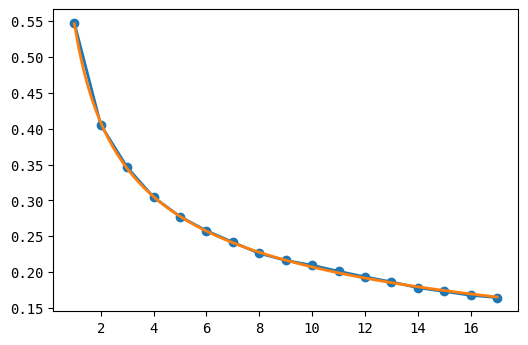

In [129]:
set_mpl_params_meeting(matplotlib)
plt.plot(aa_a.train_size//1000, aa_a.mean_vals)
plt.scatter(aa_a.train_size//1000, aa_a.mean_vals)
print(fit_params)
a,b,c,d = fit_params
x = np.linspace(1,17,100)
# plt.plot(x, -a*np.log(x**b)+c*x+d)
#plt.plot(x, -a*np.log(x**b+x**c)+d)
# plt.plot(x, -a*np.log(x**b)+d)
plt.plot(x, -a + c/x**b)

# Check if the inverse function works.
# y = np.linspace(0.15, 0.56, 1000)
# plt.plot((c /(y + a))**(1/b), y)

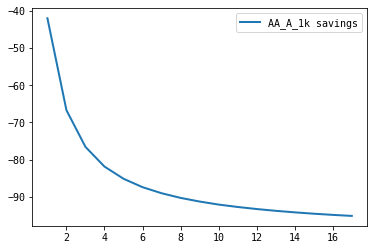

In [65]:
# for aa_a_1k

def get_xa_given_yd(y, params):
    a,b,c,d = params
    xa = (c /(y + a))**(1/b)
    return xa

aa_d_1k = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_1k.csv")
aa_a_1k = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_A_1k.csv")
x_a = aa_a_1k.train_size//1000
y_a = aa_a_1k.mean_vals
x_d = aa_d_1k.train_size//1000
y_d = aa_d_1k.mean_vals

xa = get_xa_given_yd(y_d, (a,b,c,d))

savings_1k = 100 * (xa - x_d) / x_d
# print(savings_1k)
plt.plot(aa_d_1k.train_size//1000, savings_1k, label="AA_A_1k savings")
plt.legend()

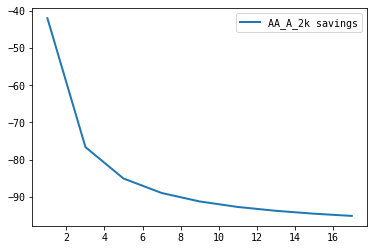

In [66]:
aa_d_2k = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_2k.csv")
x_d = aa_d_2k.train_size//1000
y_d = aa_d_2k.mean_vals

xa = get_xa_given_yd(y_d, (a,b,c,d))

savings_2k = 100 * (xa - x_d) / x_d
# print(savings_1k)
plt.plot(aa_d_2k.train_size//1000, savings_2k, label="AA_A_2k savings")
plt.legend()

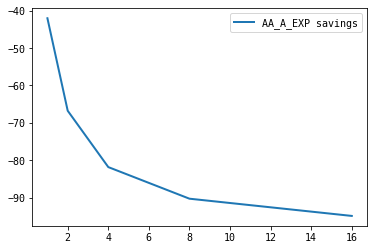

In [67]:
aa_d_exp = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_EXP.csv")
x_d = aa_d_exp.train_size//1000
y_d = aa_d_exp.mean_vals

xa = get_xa_given_yd(y_d, (a,b,c,d))

savings_exp = 100 * (xa - x_d) / x_d
# print(savings_1k)
plt.plot(aa_d_exp.train_size//1000, savings_exp, label="AA_A_EXP savings")
plt.legend()

## QM9

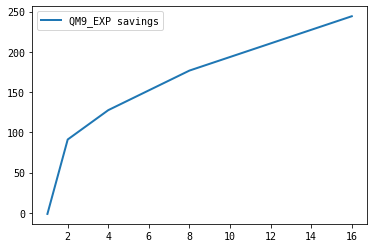

In [70]:
qm9_d_exp = pd.read_csv("csv_files/old_csvs/Active_learning_results - QM9_D_EXP.csv")
qm9_a_exp = pd.read_csv("csv_files/old_csvs/Active_learning_results - QM9_A_EXP.csv")
x_a = qm9_a_exp.train_size//1000
y_a = qm9_a_exp.mean_vals
x_d = qm9_d_exp.train_size//1000
y_d = qm9_d_exp.mean_vals

fit = scipy_fit(qm9_a_exp.train_size//1000, qm9_a_exp.mean_vals)
fit_params = fit.x
a,b,c,d = fit_params

xa = get_xa_given_yd(y_d, (a,b,c,d))

savings_exp = 100 * (xa - x_d) / x_d
# print(savings_1k)
plt.plot(qm9_d_exp.train_size//1000, savings_exp, label="QM9_EXP savings")
plt.legend()

# Fitting a polynomial using numpy polyfit

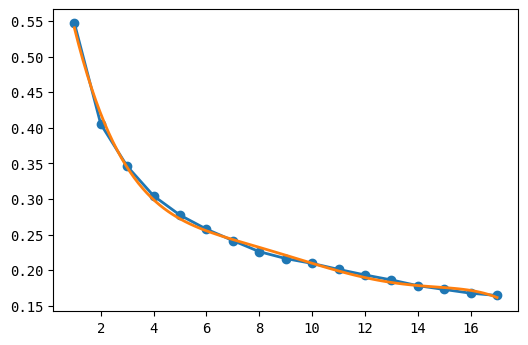

In [119]:
set_mpl_params_meeting(matplotlib)
plt.plot(aa_a.train_size//1000, aa_a.mean_vals)
plt.scatter(aa_a.train_size//1000, aa_a.mean_vals)
# try polyfit
poly = np.polyfit(aa_a.train_size//1000, aa_a.mean_vals, 5)
x = np.linspace(1,17,100)
plt.plot(x,np.polyval(poly, x))


# plt.scatter(aa_d_1k.train_size//1000, aa_d_1k.mean_vals)

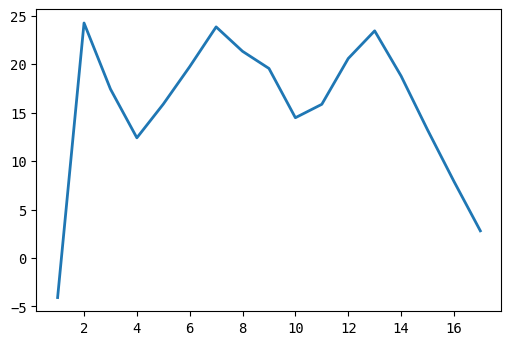

In [120]:
set_mpl_params_meeting(matplotlib)

aa_d_1k = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_1k.csv")
p = np.poly1d(poly)

def get_real_root(one_d_value):
    root = [_.real for _ in (p - one_d_value).roots if np.isreal(_)]
    assert len(root) == 1, "This value has two real root, I don't know which one to return"
    return root[0]

x_a = []
for x_d,y_d in zip(aa_d_1k.train_size//1000, aa_d_1k.mean_vals):
    xa = get_real_root(y_d)
    x_a.append(xa)

x_a = np.array(x_a)
# print(x_a)
# data savings
x_d = aa_d_1k.train_size//1000
savings_1k = 100 * (x_a - x_d) / x_d
# print(savings_1k)
plt.plot(aa_d_1k.train_size//1000, savings_1k)

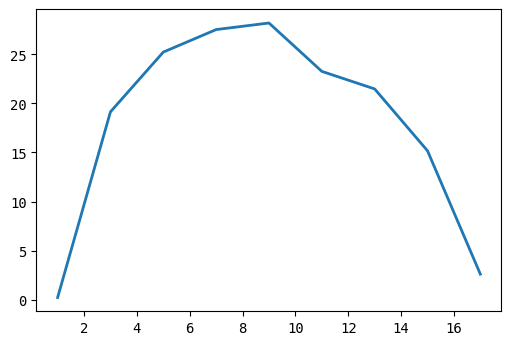

In [491]:
set_mpl_params_meeting(matplotlib)

aa_d_2k = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_2k.csv")
x_a = []
for x_d,y_d in zip(aa_d_2k.train_size//1000, aa_d_2k.mean_vals):
    xa = get_real_root(y_d)
    x_a.append(xa)

x_a = np.array(x_a)
# print(x_a)
# data savings
x_d = aa_d_2k.train_size//1000
savings_2k = 100 * (x_a - x_d) / x_d
# print(savings_1k)
plt.plot(aa_d_2k.train_size//1000, savings_2k)

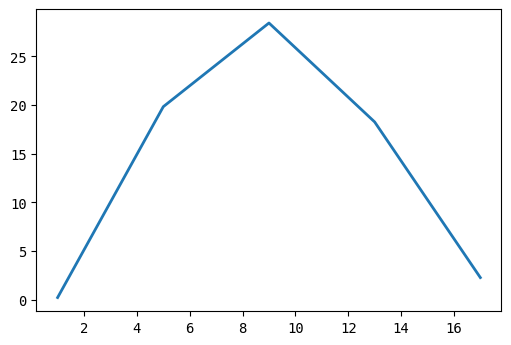

In [492]:
set_mpl_params_meeting(matplotlib)

aa_d_4k = pd.read_csv("csv_files/old_csvs/Active_learning_results - AA_D_4k.csv")
x_a = []
for x_d,y_d in zip(aa_d_4k.train_size//1000, aa_d_4k.mean_vals):
    xa = get_real_root(y_d)
    x_a.append(xa)

x_a = np.array(x_a)
# print(x_a)
# data savings
x_d = aa_d_4k.train_size//1000
savings_4k = 100 * (x_a - x_d) / x_d
# print(savings_1k)
plt.plot(aa_d_4k.train_size//1000, savings_4k)

# Distribution of molecule count per energy range

Done for AA and QM9

In [22]:
from matplotlib import pyplot as plt

import os
import numpy as np
import matplotlib
%matplotlib inline

plt.style.use('seaborn-paper')
font = {'size'   : 20}
labelsize = {'labelsize'   : 20, 'titlesize' : 20}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **labelsize)
params = {'legend.fontsize': 'small',
  'axes.labelsize': 'medium',
  'axes.titlesize':'medium',
  'xtick.labelsize':'medium',
  'ytick.labelsize':'medium'}
matplotlib.rcParams.update(params)
set_mpl_params(matplotlib)

os.chdir("/projappl/project_2000382/ghoshkun/data")
aa = np.loadtxt("AA/HOMO.txt")
qm9 = np.loadtxt("QM9/HOMO.txt")
oe = np.loadtxt("OE/HOMO.txt")

<Figure size 1200x800 with 0 Axes>

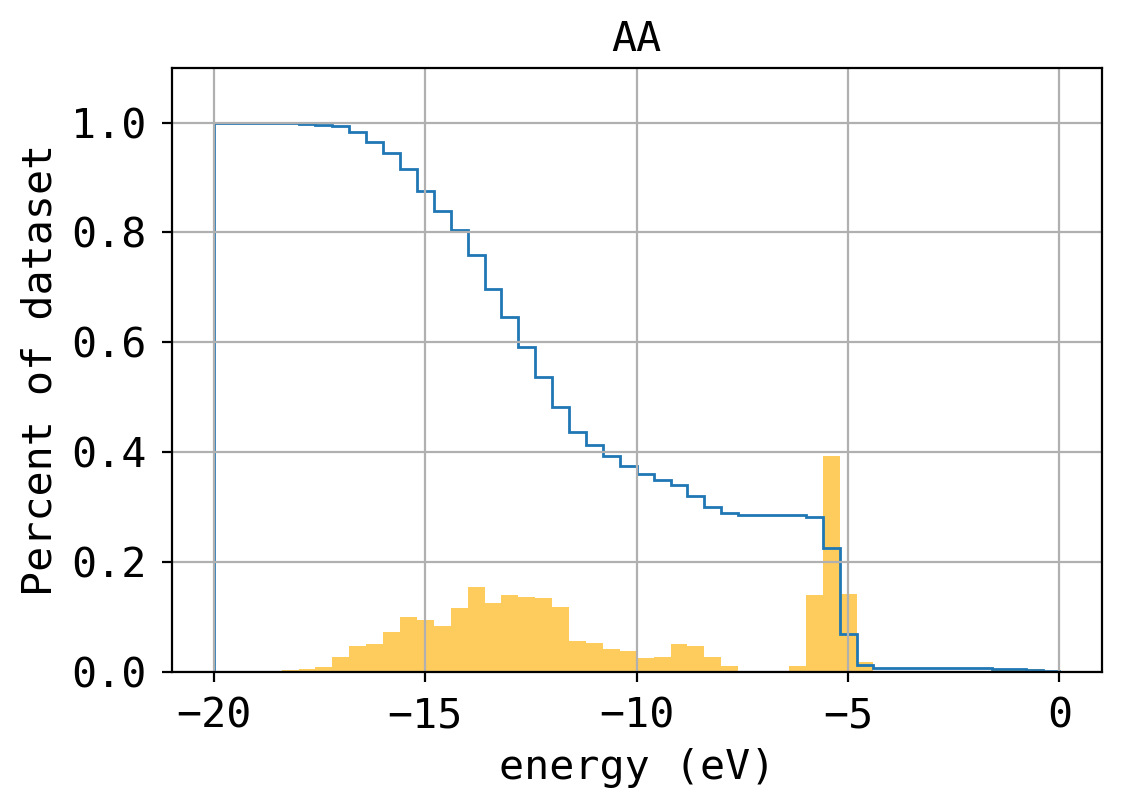

In [23]:
def plot_data_distribution(data, color, title=None, bins=50,cumulative=True, percent=True):
    set_mpl_params(matplotlib)
    n,bins,patches = plt.hist(data, bins=bins, density=percent, color=color,range=[-20, 0])
    obj = (n,bins,patches)
    
    if cumulative:
        obj_cumsum = plt.hist(data, bins=bins, density=percent, histtype='step', cumulative=-1,
            label='cumulative',range=[-20, 0], linewidth=1.0)
    
    plt.xlabel("energy (eV)")
    
    if title is not None:
        plt.title(title)
    if percent:
        plt.ylim((0,1.1))
        plt.ylabel("Percent of dataset")
    else:
        plt.ylabel("Count of molecules")
    plt.grid(True)
    return obj
    
obj_aa= plot_data_distribution(aa, "#fecc5c", title="AA")

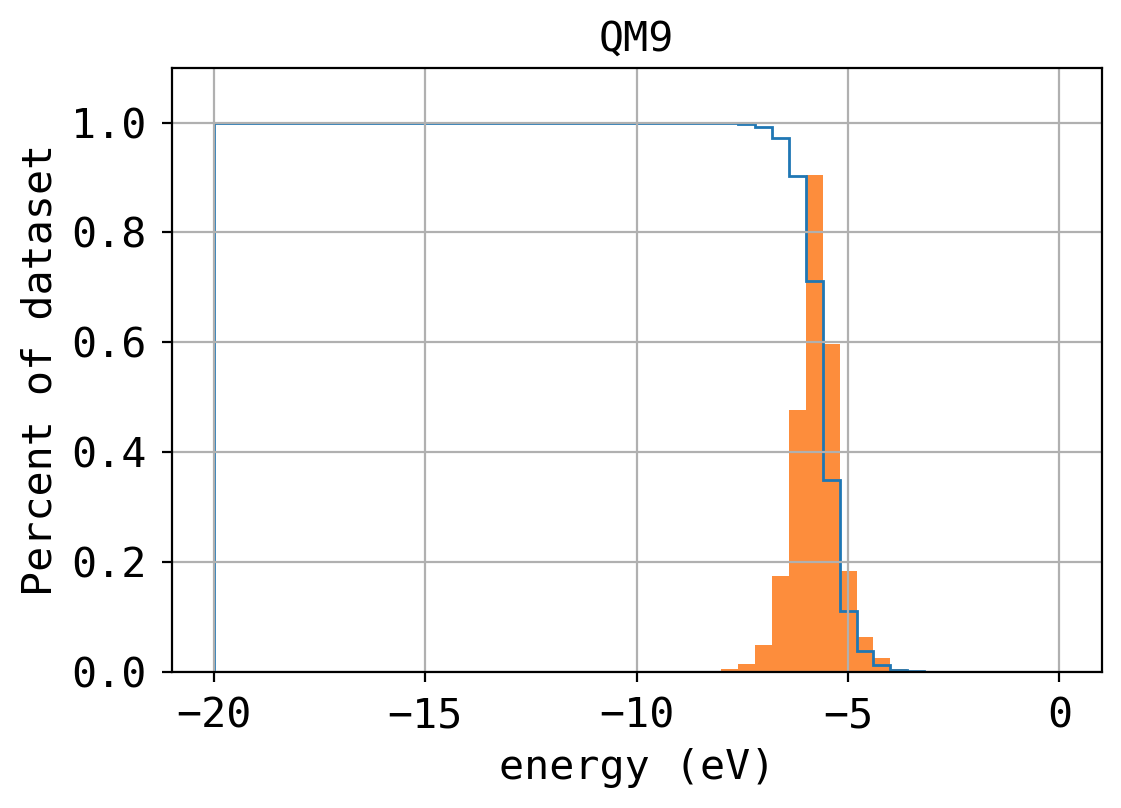

In [24]:
# obj = plt.hist(qm9, bins=50, density=True, color="#fd8d3c",range=[-20, 0])  
# plt.ylim((0,1))
# plt.xlabel("energy (eV)")
# plt.ylabel("Percent of dataset")

obj_qm9 = plot_data_distribution(qm9, "#fd8d3c", title="QM9")

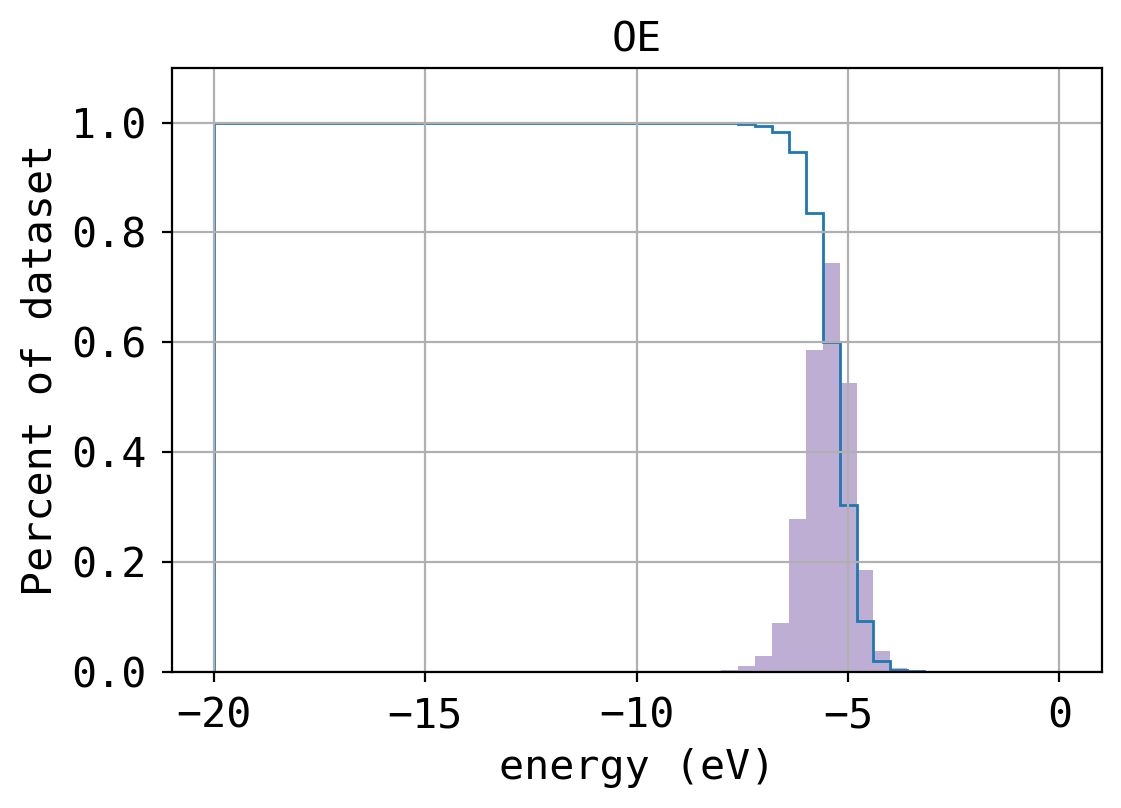

In [25]:
oe = np.loadtxt("OE/HOMO.txt")
obj_oe= plot_data_distribution(oe, "#beaed4", title="OE")

# Plot KRR data and Strategy A for AA, OE and QM9

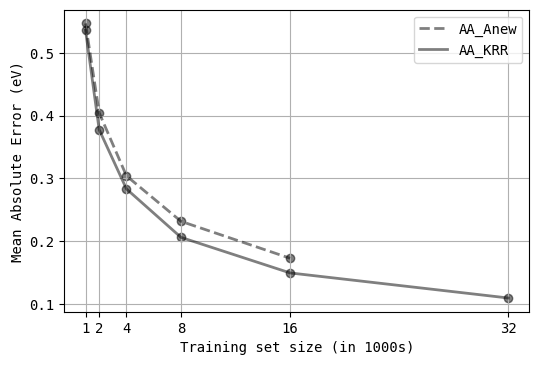

In [143]:
import pandas as pd
from matplotlib import pyplot as plt

def plot_figure_a_and_d(aa_a, qm9_a, oe_a, aa_d, qm9_d, oe_d):
    aa_a = pd.read_csv(aa_a)
    qm9_a = pd.read_csv(qm9_a)
    oe_a = pd.read_csv(oe_a)
    
    aa_d = pd.read_csv(aa_d)
    qm9_d = pd.read_csv(qm9_d)
    oe_d = pd.read_csv(oe_d)

    set_mpl_params_meeting(matplotlib)
    #plt.figure(figsize=(6,4), dpi=200)
    labs, labels = get_labels()
    
    batch_size = qm9_a.train_size // 1000
    
#     plt.plot(batch_size, qm9_a.mean_vals.to_numpy(), "--" , color="#1b9e77", alpha=0.5, label="QM9_Anew")
#     plt.scatter(batch_size, qm9_a.mean_vals.to_numpy(), color="#1b9e77", alpha =0.5)
    
#     plt.plot(qm9_d.train_size // 1000, qm9_d.mean_vals.to_numpy(), color="#1b9e77", label="QM9_KRR")
#     plt.scatter(qm9_d.train_size // 1000, qm9_d.mean_vals.to_numpy(), color="#1b9e77")
    
#     # ------------ AA -------------
    plt.plot(aa_a.train_size // 1000, aa_a.mean_vals.to_numpy(), "--" , color="k", alpha=0.5, label="AA_Anew")
    plt.scatter(aa_a.train_size // 1000, aa_a.mean_vals.to_numpy(), color="k", alpha=0.5)
    
    plt.plot(aa_d.train_size // 1000, aa_d.mean_vals.to_numpy(), color="k", alpha=0.5, label="AA_KRR")
    plt.scatter(aa_d.train_size // 1000, aa_d.mean_vals.to_numpy(), color="k", alpha=0.5)
    # ------------ OE -------------
#     print(oe_a.train_size)
#     print(oe_a.mean_vals)
#     print(oe_a.std_vals)

# #     plt.errorbar(oe_a.train_size // 1000, oe_a.mean_vals, oe_a.std_vals) #, "--" , color="tab:orange", alpha=0.5, label="OE_Anew")
#     plt.plot(oe_a.train_size // 1000, oe_a.mean_vals.to_numpy(), "--" , color="tab:orange", alpha=0.5, label="OE_Anew")
#     plt.scatter(oe_a.train_size // 1000, oe_a.mean_vals.to_numpy(), color="tab:orange", alpha=0.5)
    
#     plt.plot(batch_size, oe_d.mean_vals.to_numpy(), color="tab:orange", label="OE_KRR")
#     plt.scatter(batch_size, oe_d.mean_vals.to_numpy(), color="tab:orange")
    
    plt.xticks(batch_size)
    # plt.xscale("linear")
    plt.legend()
    plt.xlabel("Training set size (in 1000s)")
    plt.ylabel("Mean Absolute Error (eV)")
    plt.grid()
    
plot_figure_a_and_d("csv_files/Active_learning_results - AA_A_EXP.csv", 
              "csv_files/Active_learning_results - QM9_A_EXP.csv",
              "csv_files/Active_learning_results - OE_A_EXP.csv",
              "csv_files/Active_learning_results - Annika_aa.csv", 
              "csv_files/Active_learning_results - Annika_oe.csv",
              "csv_files/Active_learning_results - Annika_oe.csv")

In [129]:
aa_idxs = aa > -5
print(sum(aa_idxs))

1294


In [130]:
qm9_idxs = qm9 > -5
print(sum(qm9_idxs))

8540


In [131]:
oe_idxs = oe > -5
print(sum(oe_idxs))

11710


In [146]:
# Energy range with roughly 20% of total molecule count

print(sum(aa > -5.5) / len(aa))
print(sum(qm9 > -5.4)/ len(qm9))
print(sum(oe > -5)/ len(oe))

0.18793746023088811
0.19593615017860613
0.18096121155926442


In [38]:
print(sum(aa > -8.5) / len(aa))
print(sum(qm9 > -5.55)/ len(qm9))
print(sum(oe > -5.2)/ len(oe))

0.3044268702845196
0.3064776480786764
0.30304435172307215


In [39]:
print(sum(aa > -8.5))
print(sum(qm9 > -5.55))
print(sum(oe > -5.2))

13396
41011
19610


In [43]:
print(sum(aa > -5) / len(aa))
print(sum(qm9 > -5)/ len(qm9))
print(sum(oe > -5)/ len(oe))

0.029406417598400146
0.0638199291553948
0.18096121155926442
